In [1]:
import pandas as pd
from NegativeClassOptimization import datasets
import seaborn as sns
import NegativeClassOptimization.config as config
import matplotlib.pyplot as plt
import glob
import re
import numpy as np
from scipy.stats import pearsonr

In [2]:
def get_closed_mean(task, metric):
    closed_mean = perf_means[(perf_means['train_task'] == task) & (perf_means['test_task'] == task)][metric].values[0]
    return closed_mean

In [3]:
def add_median_labels(
    ax,
    fmt=".2f",
    fontsize=6,
    y_level=None,
    y_offset=0.002,
    x_offset=0.0,
):
    """Add labels to boxplot medians.
    https://stackoverflow.com/questions/38649501/labeling-boxplot-in-seaborn-with-median-value
    """
    import matplotlib.patheffects as path_effects

    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if type(c).__name__ == "PathPatch"]
    lines_per_box = int(len(lines) / len(boxes))
    for median in lines[4 : len(lines) : lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if (median.get_xdata()[1] - median.get_xdata()[0]) == 0 else y
        text = ax.text(
            x + x_offset,
            y + y_offset if y_level is None else y_level,
            f"{value:{fmt}}",
            ha="center",
            va="center",
            # fontweight="bold",
            color="black",
            fontsize=fontsize,
            rotation=90,  # vertical orientation
        )

In [4]:
from Bio import motifs
from Bio.Seq import Seq
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon

def get_pwm(slides_1, slides_2):
    # Create a list of Seq objects
    seqs_1 = [Seq(slide) for slide in slides_1]
    seqs_2 = [Seq(slide) for slide in slides_2]

    # Create a motifs instance
    m_1 = motifs.create(seqs_1, alphabet=config.AMINOACID_ALPHABET) # type: ignore
    m_2 = motifs.create(seqs_2, alphabet=config.AMINOACID_ALPHABET) # type: ignore

    # Get the position weight matrix
    pwm_1: np.ndarray = pd.DataFrame(m_1.pwm).values
    pwm_1 += 1e-20  # Avoid log(0)
    pwm_2: np.ndarray = pd.DataFrame(m_2.pwm).values
    pwm_2 += 1e-20  # Avoid log(0)
    return pwm_1, pwm_2

def jensen_shannon_divergence_slides(slides_1, slides_2):

    pwm_1, pwm_2 = get_pwm(slides_1, slides_2)
    return jensenshannon(pwm_1, pwm_2, axis=1, base=2).sum() 

In [5]:
pellets = {'color_blind_light':['#a2c8ec','#cfcfcf', '#ffbc79'], 
'color_blind_dark':['#5CA7E5','#ababab', '#ff7700'],
'r_like':['#94669E', '#F2D81D', '#00817A'],
'chat_gpt': ['#FFC300', '#FF5733', '#00A6ED'],
'antigens': ['#008080','#FFA07A','#000080','#FFD700','#228B22','#FF69B4','#800080','#FF6347','#00FF00','#FF1493']}

cmap = { 'vs 9' : '#FF5733',
         'vs Non-binder':'#00A6ED',
         'vs Weak':'#FFC300',
         'vs 1': '#8B5F4D'}

ag_order = [
        "1FBI",
        "3VRL",
        "2YPV",
        "5E94",
        "1WEJ",
        "1OB1",
        "1NSN",
        "1H0D",
        "3RAJ",
        "1ADQ",
    ]
#task_order = ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]
task_clean_order = ['vs Non-binder', 'vs 1', 'vs 9', 'vs Weak']

folder_2_task = {'1v9': 'vs 9', 'high_vs_95low': 'vs Non-binder', 'high_vs_looser': 'vs Weak', '1v1': 'vs 1'}
task_2_folder = {'vs 9':'1v9', 'vs Non-binder':'high_vs_95low', 'vs Weak': 'high_vs_looser', 'vs 1':'1v1'}

In [8]:
perf_df = pd.read_csv('../data/openset_performance.tsv', sep='\t')


In [9]:
perf_df.head()

task_1                             task_2  \
0    ONE_VS_NINE__3VRL__auto__0__42     ONE_VS_NINE__3VRL__auto__0__42   
1    ONE_VS_NINE__3VRL__auto__0__42   HIGH_VS_95LOW__3VRL__auto__0__42   
2    ONE_VS_NINE__3VRL__auto__0__42  HIGH_VS_LOOSER__3VRL__auto__0__42   
3  HIGH_VS_95LOW__3VRL__auto__0__42     ONE_VS_NINE__3VRL__auto__0__42   
4  HIGH_VS_95LOW__3VRL__auto__0__42   HIGH_VS_95LOW__3VRL__auto__0__42   

        acc  recall  precision        f1  
0  0.972986   0.975   0.971116  0.973054  
1  0.987000   0.975   0.998975  0.986842  
2  0.882900   0.975   0.823341  0.892775  
3  0.912356   0.998   0.852117  0.919307  
4  0.996600   0.998   0.995213  0.996605

In [10]:
perf_df[['train_task', 'train_ag', 'train_neg', 'seed_id', 'split_id']] = perf_df.task_1.str.split('__', expand=True)
perf_df[['test_task', 'test_ag', 'test_neg', 'test_seed_id', 'test_split_id']] = perf_df.task_2.str.split('__', expand=True)
perf_df.drop(['task_1', 'task_2'], inplace=True, axis=1)
task_rename = {'ONE_VS_NINE': 'vs 9', 'HIGH_VS_95LOW': 'vs Non-binder', 'HIGH_VS_LOOSER': 'vs Weak'}
perf_df['train_task'] = perf_df['train_task'].apply(lambda x: task_rename[x])
perf_df['test_task'] = perf_df['test_task'].apply(lambda x: task_rename[x])

In [11]:
perf_df.columns

Index(['acc', 'recall', 'precision', 'f1', 'train_task', 'train_ag',
       'train_neg', 'seed_id', 'split_id', 'test_task', 'test_ag', 'test_neg',
       'test_seed_id', 'test_split_id'],
      dtype='object')

In [12]:
df_1vs1 = pd.read_csv('../data/1vs1_perf.tsv', sep='\t', index_col=0)

df_1vs1_open = pd.read_csv('../data/1vs1_perf_open.tsv', sep='\t', index_col=0)
df_1vs1_open['test_neg'] = 'auto'

perf_on_vs1 = pd.read_csv('../data/perf_on_vs1.tsv', sep='\t', index_col=0)
perf_on_vs1.rename(columns={'pos_ag':'train_ag', 'neg_ag':'train_neg', 'pos_ag.1':'test_ag', 'neg_ag.1':'test_neg','prec':'precision'}, inplace=True)
perf_on_vs1.drop(['seed_id.1', 'split_id.1'], inplace=True, axis=1)
perf_on_vs1['train_neg'] = 'auto'
perf_on_vs1['train_task'] = perf_on_vs1['train_task'].apply(lambda x: folder_2_task[x])
#perf_df.drop(columns=['test_split_id', 'test_seed_id'], inplace=True, axis=1)
#df_1vs1_open.drop(columns=['test_split_id', 'test_seed_id'], inplace=True, axis=1)
df_1vs1_open['test_task'] = df_1vs1_open['test_task'].apply(lambda x: folder_2_task[x])
perf_df = pd.concat([perf_df,df_1vs1, df_1vs1_open, perf_on_vs1], axis=0)

perf_open_df = perf_df[perf_df['train_task'] != perf_df['test_task']]
df_closed = perf_df[perf_df['train_task'] == perf_df['test_task']]

In [13]:
tasks = perf_df['train_task'].unique()

In [14]:
pellets['chat_gpt']
'#00A6ED', '#FF5733', '#FFC300'

('#00A6ED', '#FF5733', '#FFC300')

In [15]:
perf_wo_1 = perf_df[(perf_df['test_task'] != 'vs 1') & (perf_df['train_task'] != 'vs 1')]

In [16]:
#might be deleted
# perf_df[perf_df['test_task'] != 'vs 1']
#perf_wo_1


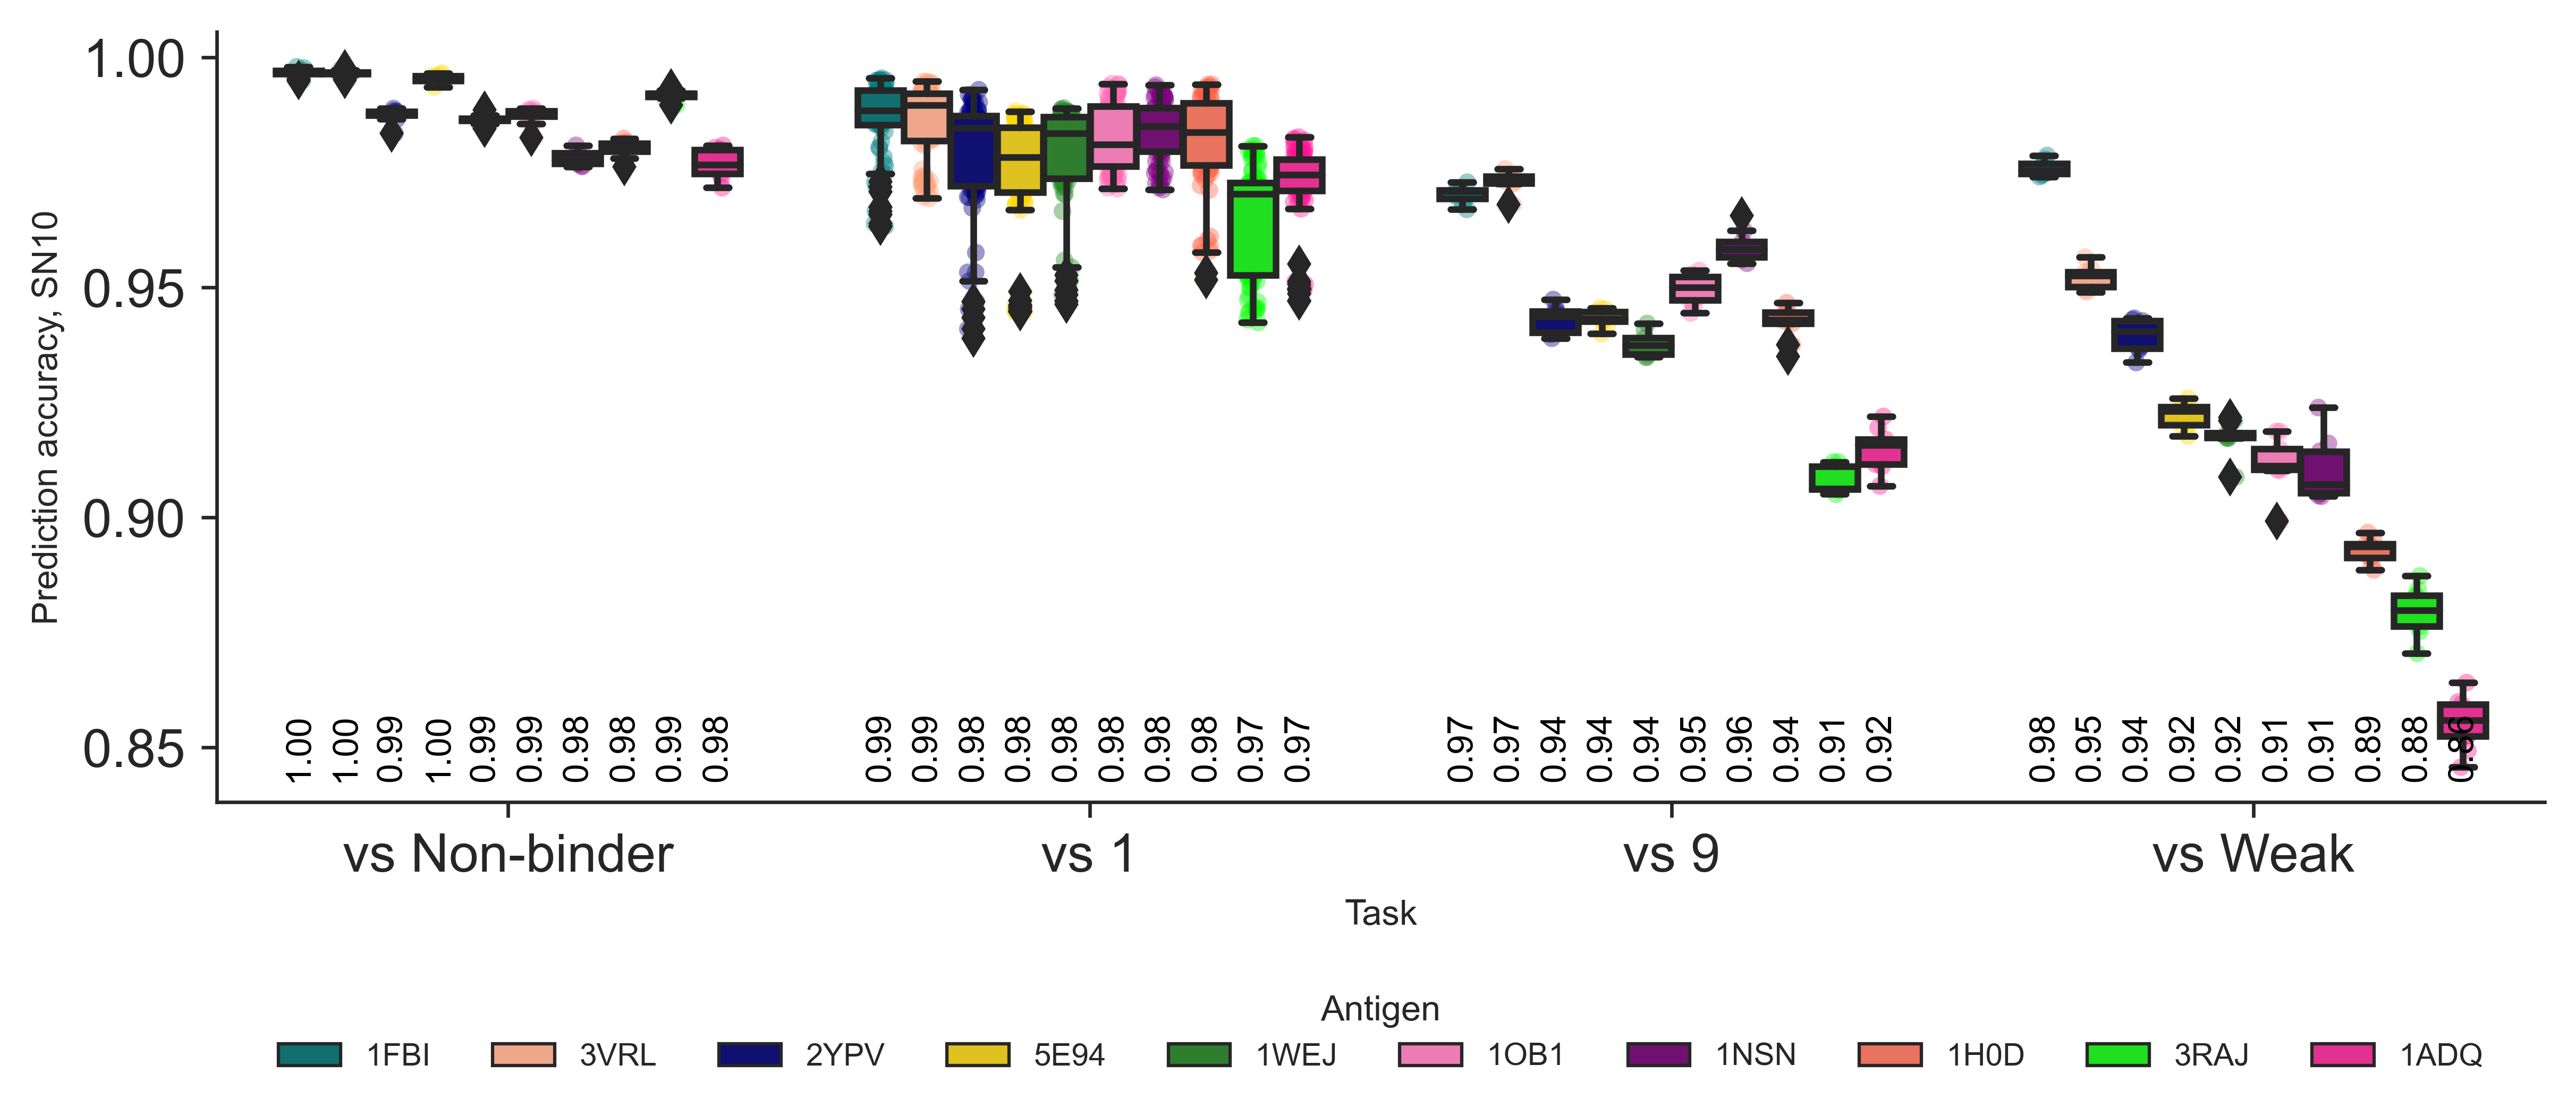

In [17]:
plt.rcParams['svg.fonttype'] = 'none'
#yticks = np.arange(0.85, 1.0, 0.05)
plt.rcParams['svg.fonttype'] = 'none'
yaxis_title = "Prediction accuracy, SN10"
ag_order = [
        "1FBI",
        "3VRL",
        "2YPV",
        "5E94",
        "1WEJ",
        "1OB1",
        "1NSN",
        "1H0D",
        "3RAJ",
        "1ADQ",
    ]
#task_order = ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]
task_clean_order = ['vs Non-binder', 'vs 1', 'vs 9', 'vs Weak']#['vs Non-binder','vs 1', 'vs 9', 'vs Loose']

sns.set_style("white")
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(3 * 3.14, 3.14), dpi=600)

stripplot = sns.stripplot(
    x="train_task",
    y="acc",
    hue="train_ag",
    data=df_closed,
    ax=ax,
    order=task_clean_order,
    hue_order=ag_order,
    palette=pellets['antigens'],
    alpha=0.4,
    dodge=True,
    size=4,
    legend=False, # type: ignore
    zorder=1 
)

# Transparent boxplot
boxplot = sns.boxplot(
    x="train_task",
    y="acc",
    hue="train_ag",
    data=df_closed,
    ax=ax,
    order=task_clean_order,
    hue_order=ag_order,
    palette=pellets['antigens'],
    boxprops=dict(alpha=1),
    zorder=2
    )

for artist in stripplot.collections:
    artist.set_zorder(1)

# Set the z-order of the boxplot patches to be higher than that of the stripplot
for artist in boxplot.patches:
    artist.set_zorder(2)

add_median_labels(ax, y_level=0.85, fontsize=8)


ax.tick_params(labelsize=12)
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Antigen",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)

ax.set_xlabel("Task", fontsize=8)
ax.set_ylabel(yaxis_title, fontsize=8)
yticks = np.arange(0.85, 1.0, 0.05)
ax.set_yticks(yticks)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig('./figures/by_task_closed.svg')

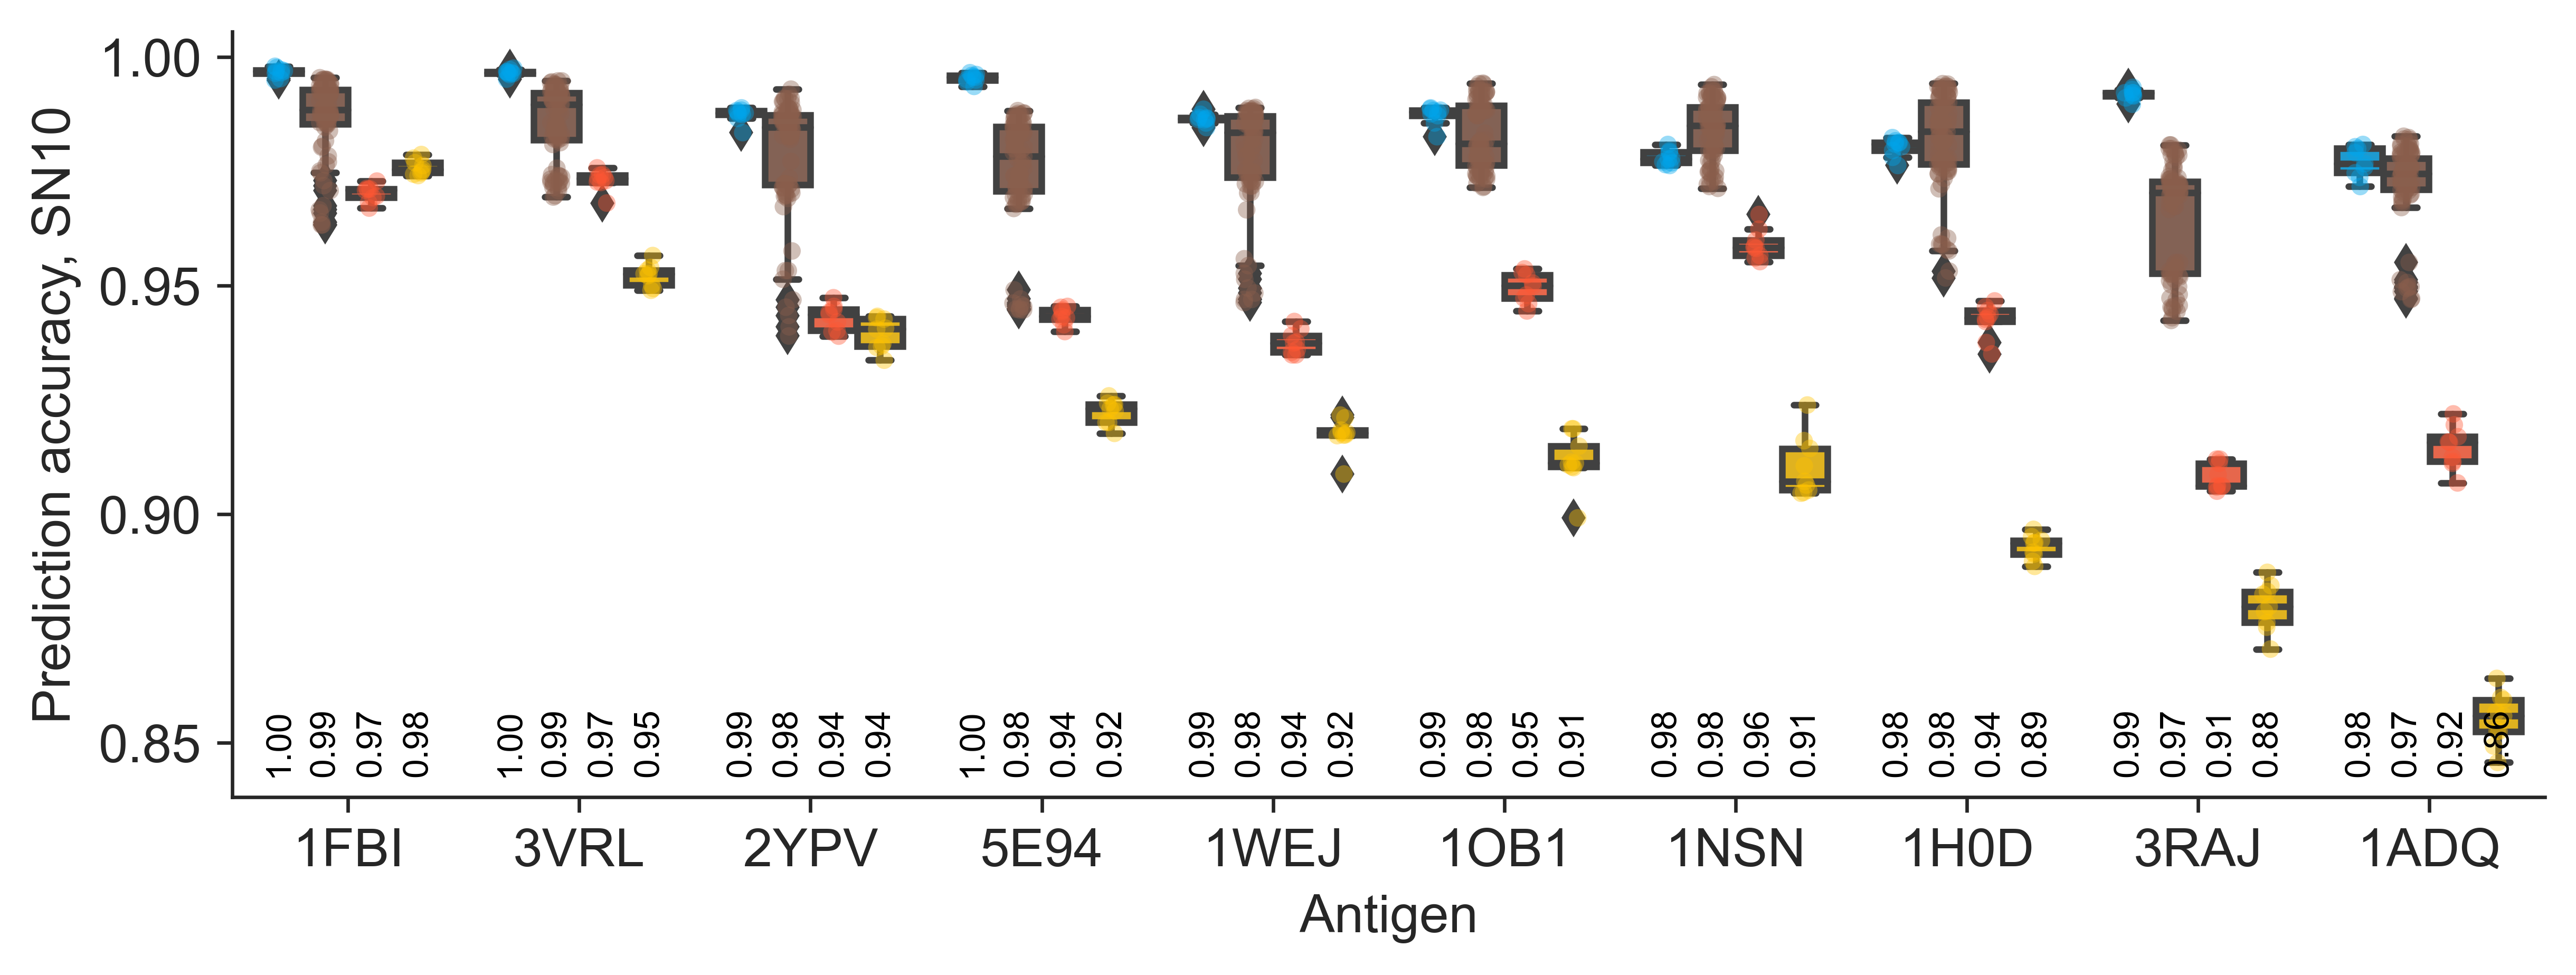

In [18]:

fig, ax = plt.subplots(figsize=(3 * 3.14, 3.14), dpi=600)
sns.set_style("white")
sns.set_style('ticks')

## Add data points on top of boxplot in low transparency
sns.stripplot(
    x="train_ag",
    y="acc",
    hue="train_task",
    data=df_closed,
    ax=ax,
    # Order on x axis
    order=ag_order,
    hue_order=["vs Non-binder", 'vs 1', "vs 9", "vs Weak"],
    # palette="Set2",
    palette=['#00A6ED', '#8B5F4D', '#FF5733', '#FFC300'],
    alpha=0.4,
    dodge=True,
    size=4,
    legend=False, # type: ignore
)

sns.boxplot(
    x="train_ag",
    y="acc",
    hue="train_task",
    data=df_closed,
    ax=ax,
    order=ag_order,
    boxprops=dict(alpha=1),  # a better solution is below
    hue_order=["vs Non-binder", "vs 1", "vs 9", "vs Weak"],
    palette=['#00A6ED', '#8B5F4D', '#FF5733', '#FFC300'],
)
## Based on https://github.com/mwaskom/seaborn/issues/979#issuecomment-235082271
for patch in ax.artists:
    fc = patch.get_facecolor()
    patch.set_facecolor(mpl.colors.to_rgba(fc, 0.1))
    
add_median_labels(ax, y_level=0.85, fontsize=8)

FONT_SIZE = 12
ax.tick_params(labelsize=FONT_SIZE)

ax.set_xlabel("Antigen", fontsize=FONT_SIZE)
ax.set_ylabel(yaxis_title, fontsize=FONT_SIZE)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
yticks = np.arange(0.85, 1.0, 0.05)
ax.set_yticks(yticks)
# remore legend
ax.get_legend().remove()
fig.savefig('./figures/by_ag_closed.svg')


In [19]:
EXECUTE = False
if EXECUTE:
    jsds = []
    for task in tasks:
        datasets_paths = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/{task_2_folder[task]}/seed_*/split_*/*/*_test_dataset.tsv') #why we did on test? see what happens on train.
        for path in datasets_paths:
            df = pd.read_csv(path, sep='\t')
            slides_pos = df[df['y'] == 1]['Slide'].to_list()
            slides_neg = df[df['y'] == 0]['Slide'].to_list()
            jsd = jensen_shannon_divergence_slides(slides_neg, slides_pos)
            train_task = task
            seed = path.split('/')[4].split('_')[1]
            split = path.split('/')[5].split('_')[1]
            if task == 'vs 1':
                train_ag = path.split('/')[6].split('__')[0]
                train_neg = path.split('/')[6].split('__')[2]
                seed = int(path.split('/')[4].split('_')[1])
                split = int(path.split('/')[5].split('_')[1])
            else:
                train_ag = path.split('/')[6].split('__')[0].split('_')[0]
                train_neg = 'auto'
            try:
                acc = df_closed[(df_closed['train_task'] == train_task) & (df_closed['train_ag'] == train_ag) &\
                        (df_closed['train_neg'] == train_neg) & (df_closed['seed_id'] == seed) & (df_closed['split_id'] == split)]['acc'].values[0]
                jsds.append([train_task, jsd, acc, train_ag, train_neg, seed, split])
            except:
                print(path)
    df_jsds = pd.DataFrame(jsds, columns=['train_task', 'jsd', 'acc', 'train_ag', 'train_neg', 'seed', 'split'])
    df_jsds.to_csv('./jsd_ection1.csv')

In [45]:
df_jsds = pd.read_csv('./jsd_ection1.csv')
df_jsds.drop('Unnamed: 0', axis=1, inplace=True)

In [49]:
df_jsds['dupl_filter'] = df_jsds.apply(lambda row: '_'.join(row[['train_ag','train_neg']]) + '_' + row['train_task'], axis=1)
df_jsds_means = df_jsds.groupby('dupl_filter').mean()
df_jsds_wo_dupl = df_jsds.drop_duplicates('dupl_filter')
#We drop duplicates in vs 1 since jsd is simmetrical, and drop seeds replicates, they do't change jsd as well

In [50]:
df_jsds_means

jsd       acc  seed  split
dupl_filter                                             
1ADQ_1FBI_vs 1           3.876352  0.981210   0.6   22.0
1ADQ_1H0D_vs 1           3.209635  0.976370   0.6   22.0
1ADQ_1NSN_vs 1           3.478722  0.976320   0.6   22.0
1ADQ_1OB1_vs 1           3.243824  0.978380   0.6   22.0
1ADQ_1WEJ_vs 1           3.581892  0.972260   0.6   22.0
...                           ...       ...   ...    ...
5E94_3RAJ_vs 1           2.916260  0.945860   0.6   22.0
5E94_3VRL_vs 1           4.926536  0.982400   0.6   22.0
5E94_auto_vs 9           2.872243  0.943452   0.6   22.0
5E94_auto_vs Non-binder  3.530181  0.995350   0.6   22.0
5E94_auto_vs Weak        1.642270  0.922180   0.6   22.0

[120 rows x 4 columns]

In [51]:
#need to be fixed
df_jsds_means.reset_index(inplace=True)
df_jsds_means['train_ag'] = df_jsds_means.apply(lambda row: row['dupl_filter'].split('_')[0], axis=1)
df_jsds_means[['train_ag','neg_ag','train_task']] = df_jsds_means.dupl_filter.str.split('_', expand=True)

In [52]:
df_jsds_means[['train_ag','neg_ag','train_task']] = df_jsds_means.dupl_filter.str.split('_', expand=True)

In [53]:
df_jsds_means.drop(columns=['dupl_filter'], inplace=True)

In [54]:
df_jsds_means.train_ag.unique()

array(['1ADQ', '1FBI', '1H0D', '1NSN', '1OB1', '1WEJ', '2YPV', '3RAJ',
       '3VRL', '5E94'], dtype=object)

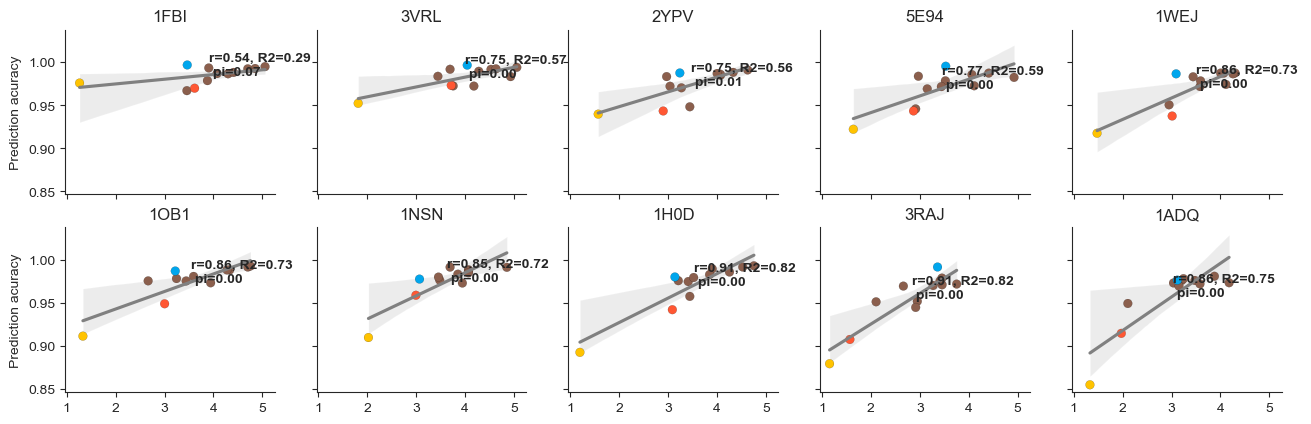

In [56]:
plt.rcParams['svg.fonttype'] = 'none'
sns.set_style("white")
sns.set_style('ticks')

#open performance
perf_wo_1 = perf_df[(perf_df['test_task'] != 'vs 1') & (perf_df['train_task'] != 'vs 1')]
fig, ax = plt.subplots(2,5,figsize= (5 * 3.14, 1.5 * 3.14), sharey=True, sharex=True)
sns.set_style('ticks')
# set font size
for i, ag in enumerate(ag_order):
    r = i //5
    c = i % 5
    df = df_jsds_means[df_jsds_means['train_ag'] == ag]
    ax_=ax[r,c]

    sns.regplot(df, x='jsd', y='acc', ax=ax_, color='grey', marker='.')
    sns.scatterplot(df, x='jsd', y='acc', hue='train_task', ax=ax_, palette=cmap, edgecolor='black',linewidth=0.1, s=40)

    x = df["jsd"].mean()
    y = df["acc"].mean()
    r, pval = pearsonr(df["jsd"], df["acc"])
    ax_.text(x, y, f"r={r:.2f}, R2={r**2:.2f} \n pi={pval:.2f}" , fontsize=10, fontweight="bold")

    ax_.legend().set_visible(False)
    ax_.set_title(ag, fontsize=12)
    if c!=0:
       ax_.set_ylabel('')
    else:
        ax_.set_ylabel('Prediction acuracy')
    #remove xlabel
    ax_.set_xlabel('')

    #make y axis a bit more sparce 
    yticks = np.arange(0.85, 1.0, 0.05)
    ax_.set_yticks(yticks)

    #set font size
    #ax[r,c].tick_params(axis='both', which='major', labelsize=8)
    #REMOVE upper and right spines
    ax_.spines['right'].set_visible(False)
    ax_.spines['top'].set_visible(False)

#one legend for all subplots
handles, labels = ax[0,0].get_legend_handles_labels()

fig.savefig('./figures/closed_jsd_vs_acc_by_ag.svg')
#TODO: change x-labels, y-label, make y-tick labels bigger, add lehend with handles 


/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_16653/1628496743.py:52: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


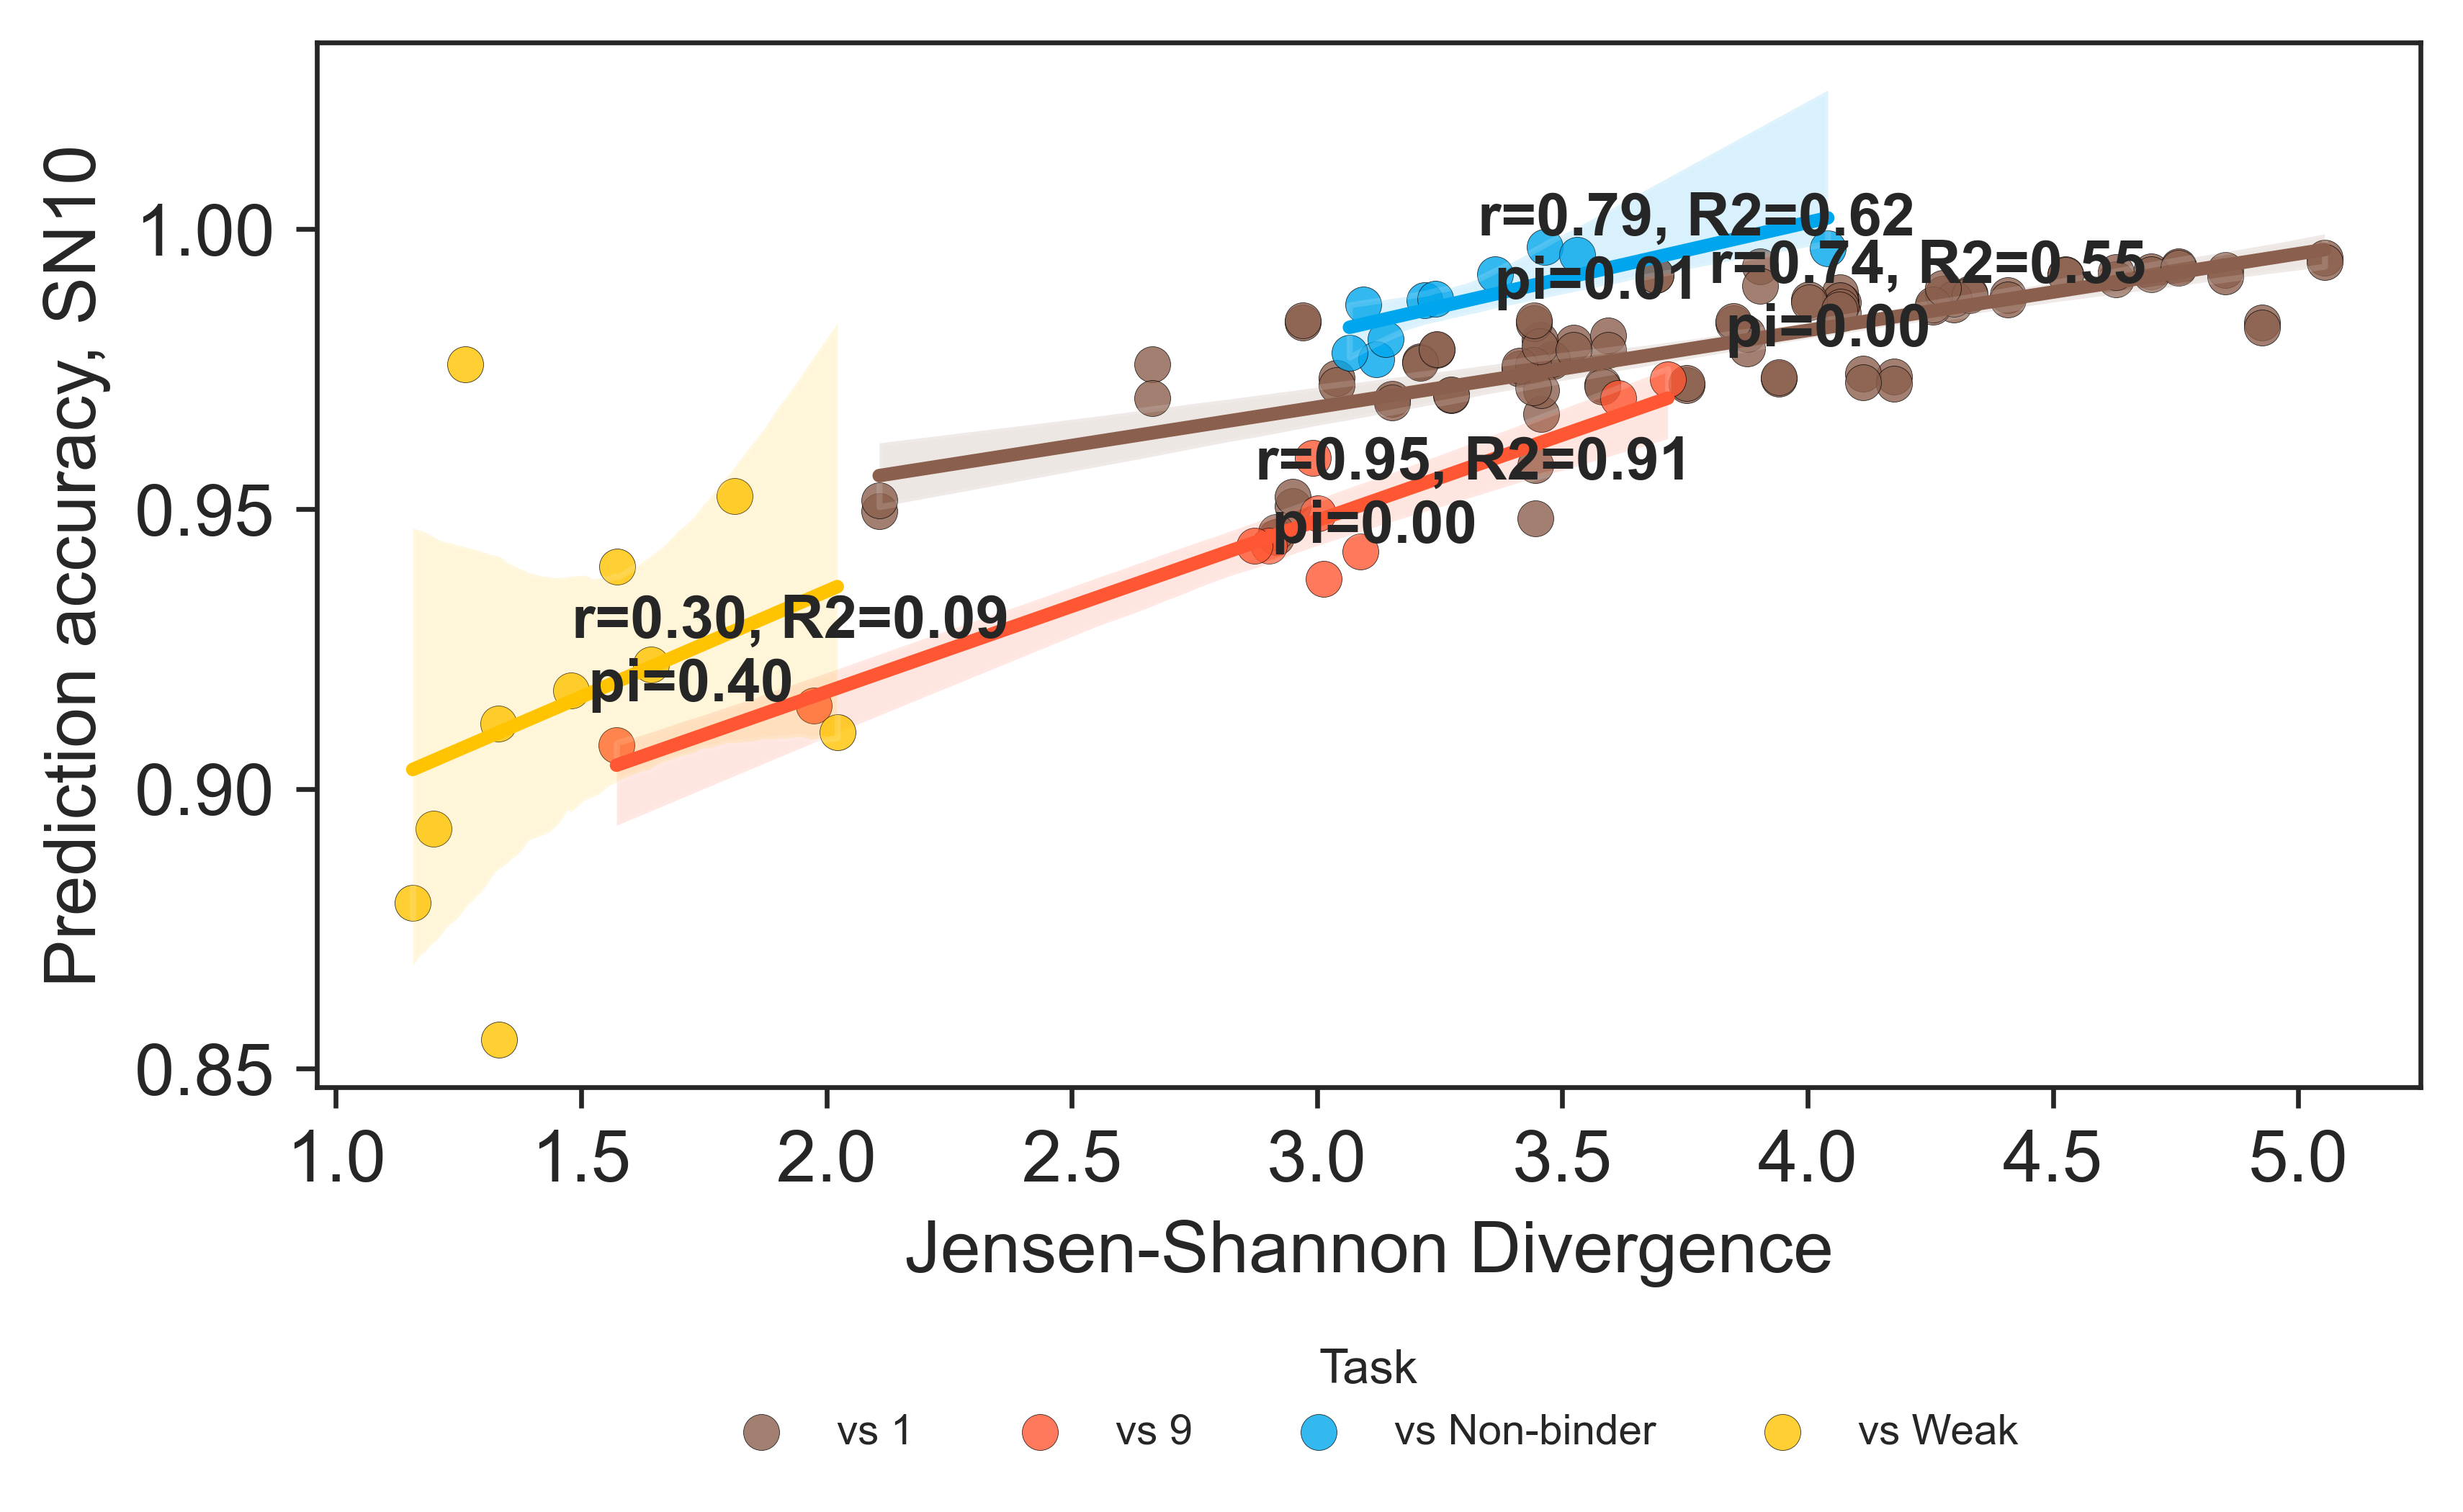

In [57]:
cmap = { 'vs 9' : '#FF5733',
         'vs Non-binder':'#00A6ED',
         'vs Weak':'#FFC300',
         'vs 1': '#8B5F4D'}

sns.set_style("white")
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)

# Line plot in seaborn with R2 regression
for task, df_g in df_jsds_means.groupby("train_task"):
    sns.regplot(
        x="jsd",
        y="acc",
        data=df_g,
        scatter=True,
        ax=ax,
        label=task,
        color=cmap[task],
        scatter_kws={'edgecolor': 'black', 'linewidth': 0.1} 
    )

    # Compute Pearson correlation
    r, pval = pearsonr(df_g["jsd"], df_g["acc"])
    # Add text with r and R2 at centroid
    x = df_g["jsd"].mean()
    y = df_g["acc"].mean()
    ax.text(x, y, f"r={r:.2f}, R2={r**2:.2f} \n pi={pval:.2f}" , fontsize=10, fontweight="bold")

FONT_SIZE = 12
ax.tick_params(labelsize=FONT_SIZE)
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Task",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)

#get_regression_correlatrion("jsd", "acc", df_jsds_wo_dupl, ax, "Task")

ax.set_xlabel("Jensen-Shannon Divergence", fontsize=FONT_SIZE)
ax.set_ylabel(yaxis_title, fontsize=FONT_SIZE)
yticks = np.arange(0.85, 1.0, 0.05)
ax.set_yticks(yticks)


# put legend to the bottom
fig.show()
fig.savefig('./figures/closed_jsd_vs_acc_avg.svg')

In [58]:
df_jsds_means.groupby("train_task").count()
# equate the number of points. Since JSD is symmetric, half can be removed

jsd  acc  seed  split  train_ag  neg_ag
train_task                                            
vs 1            90   90    90     90        90      90
vs 9            10   10    10     10        10      10
vs Non-binder   10   10    10     10        10      10
vs Weak         10   10    10     10        10      10

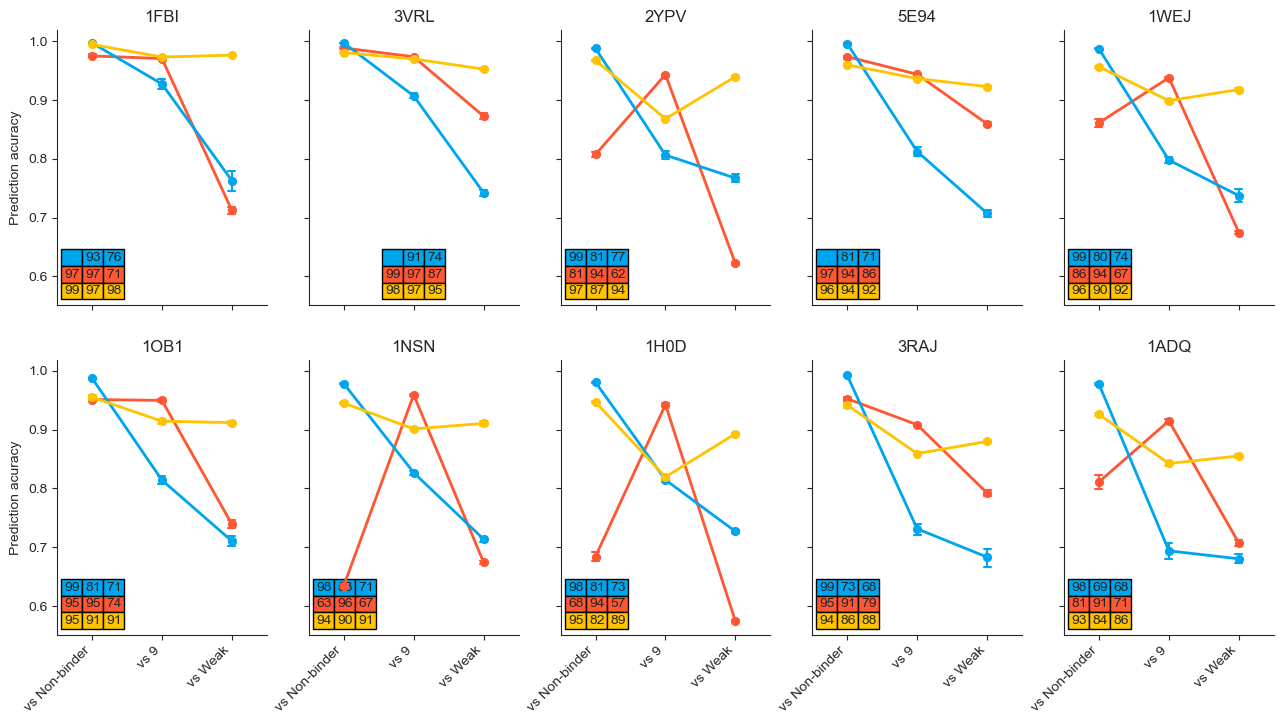

In [61]:
#open performance
perf_wo_1 = perf_df[(perf_df['test_task'] != 'vs 1') & (perf_df['train_task'] != 'vs 1')]
fig, ax = plt.subplots(2,5,figsize= (5 * 3.14, 2.5* 3.14), sharey=True, sharex=True)
sns.set_style('ticks')
# set font size
for i, ag in enumerate(ag_order):
    r = i //5
    c = i % 5
    sns.pointplot(perf_wo_1[perf_wo_1['train_ag'] == ag], x='test_task', y='acc', order = ['vs Non-binder', 'vs 9', 'vs Weak'],  \
        hue='train_task',  errorbar= ('ci', 95),  palette = cmap, ax=ax[r,c], scale=0.75, capsize=.1, errwidth=1.5)
    ax[r,c].legend().set_visible(False)
    ax[r,c].set_title(ag, fontsize=12)
    # set_horizontalalignment 

    if c!=0:
       ax[r,c].set_ylabel('')
    else:
        ax[r,c].set_ylabel('Prediction acuracy')
    #remove xlabel
    ax[r,c].set_xlabel('')

    #rotate xticks
    ax[r,c].set_xticklabels(ax[r,c].get_xticklabels(), rotation=45) 
    for tick in ax[r,c].get_xticklabels():
        tick.set_horizontalalignment("right")

    #set font size
    #ax[r,c].tick_params(axis='both', which='major', labelsize=8)
    #REMOVE upper and right spines
    ax[r,c].spines['right'].set_visible(False)
    ax[r,c].spines['top'].set_visible(False)

     # Tables inside the plot
    if r == 0 and c == 1:
        loc = "lower center"
    else:
        loc = "lower left"
    table_values = (perf_wo_1[perf_wo_1['train_ag'] == ag].groupby(["train_task", "test_task"])["acc"].mean()\
    .reset_index().pivot(index="train_task", columns="test_task", values="acc")\
    .reindex(['vs Non-binder', 'vs 9', 'vs Weak'], axis=1).reindex(['vs Non-binder', 'vs 9', 'vs Weak'], axis=0)\
    .values * 100).round().astype('int')
    table_values = np.where(table_values == 100, "", table_values)
    ax[r,c].table(
        cellText=table_values,
        loc=loc,
        colWidths=[0.1, 0.1, 0.1],
        cellColours=np.array([['#00A6ED', '#FF5733', '#FFC300'] for _ in range(3)]).transpose(),
    )
    #line width 
    



# set common x axis label
#fig.text(0.5, 0, 'Test task', ha='center', va='center')

#one legend for all subplots
handles, labels = ax[0,0].get_legend_handles_labels()
"""fig.legend(
    handles,
    labels,
    loc="upper center",
    ncol=5,
    fontsize=8,
    frameon=False,
    # title="Model trained on",
    title_fontsize=8,
)"""
fig.savefig('./figures/openset_performance.svg')

#TODO: change x-labels, y-label, make y-tick labels bigger, add lehend with handles 


In [63]:
perf_wo_1

acc  recall  precision        f1     train_task train_ag train_neg  \
0    0.972986  0.9750   0.971116  0.973054           vs 9     3VRL      auto   
1    0.987000  0.9750   0.998975  0.986842           vs 9     3VRL      auto   
2    0.882900  0.9750   0.823341  0.892775           vs 9     3VRL      auto   
3    0.912356  0.9980   0.852117  0.919307  vs Non-binder     3VRL      auto   
4    0.996600  0.9980   0.995213  0.996605  vs Non-binder     3VRL      auto   
..        ...     ...        ...       ...            ...      ...       ...   
805  0.988000  0.9946   0.981642  0.988079  vs Non-binder     1OB1      auto   
806  0.720900  0.9946   0.642756  0.780875  vs Non-binder     1OB1      auto   
807  0.916558  0.9224   0.911823  0.917081        vs Weak     1OB1      auto   
808  0.959200  0.9224   0.995682  0.957641        vs Weak     1OB1      auto   
809  0.918700  0.9224   0.915624  0.919000        vs Weak     1OB1      auto   

    seed_id split_id      test_task test_ag test_neg test_seed_id  \
0         0       42           vs 9    3VRL     auto            0   
1         0       42  vs Non-binder    3VRL     auto            0   
2         0       42        vs Weak    3VRL     auto            0   
3         0       42           vs 9    3VRL     auto            0   
4         0       42  vs Non-binder    3VRL     auto            0   
..      ...      ...            ...     ...      ...          ...   
805       0        4  vs Non-binder    1OB1     auto            0   
806       0        4        vs Weak    1OB1     auto            0   
807       0        4           vs 9    1OB1     auto            0   
808       0        4  vs Non-binder    1OB1     auto            0   
809       0        4        vs Weak    1OB1     auto            0   

    test_split_id  
0              42  
1              42  
2              42  
3              42  
4              42  
..            ...  
805             4  
806             4  
807             4  
808             4  
809             4  

[810 rows x 14 columns]

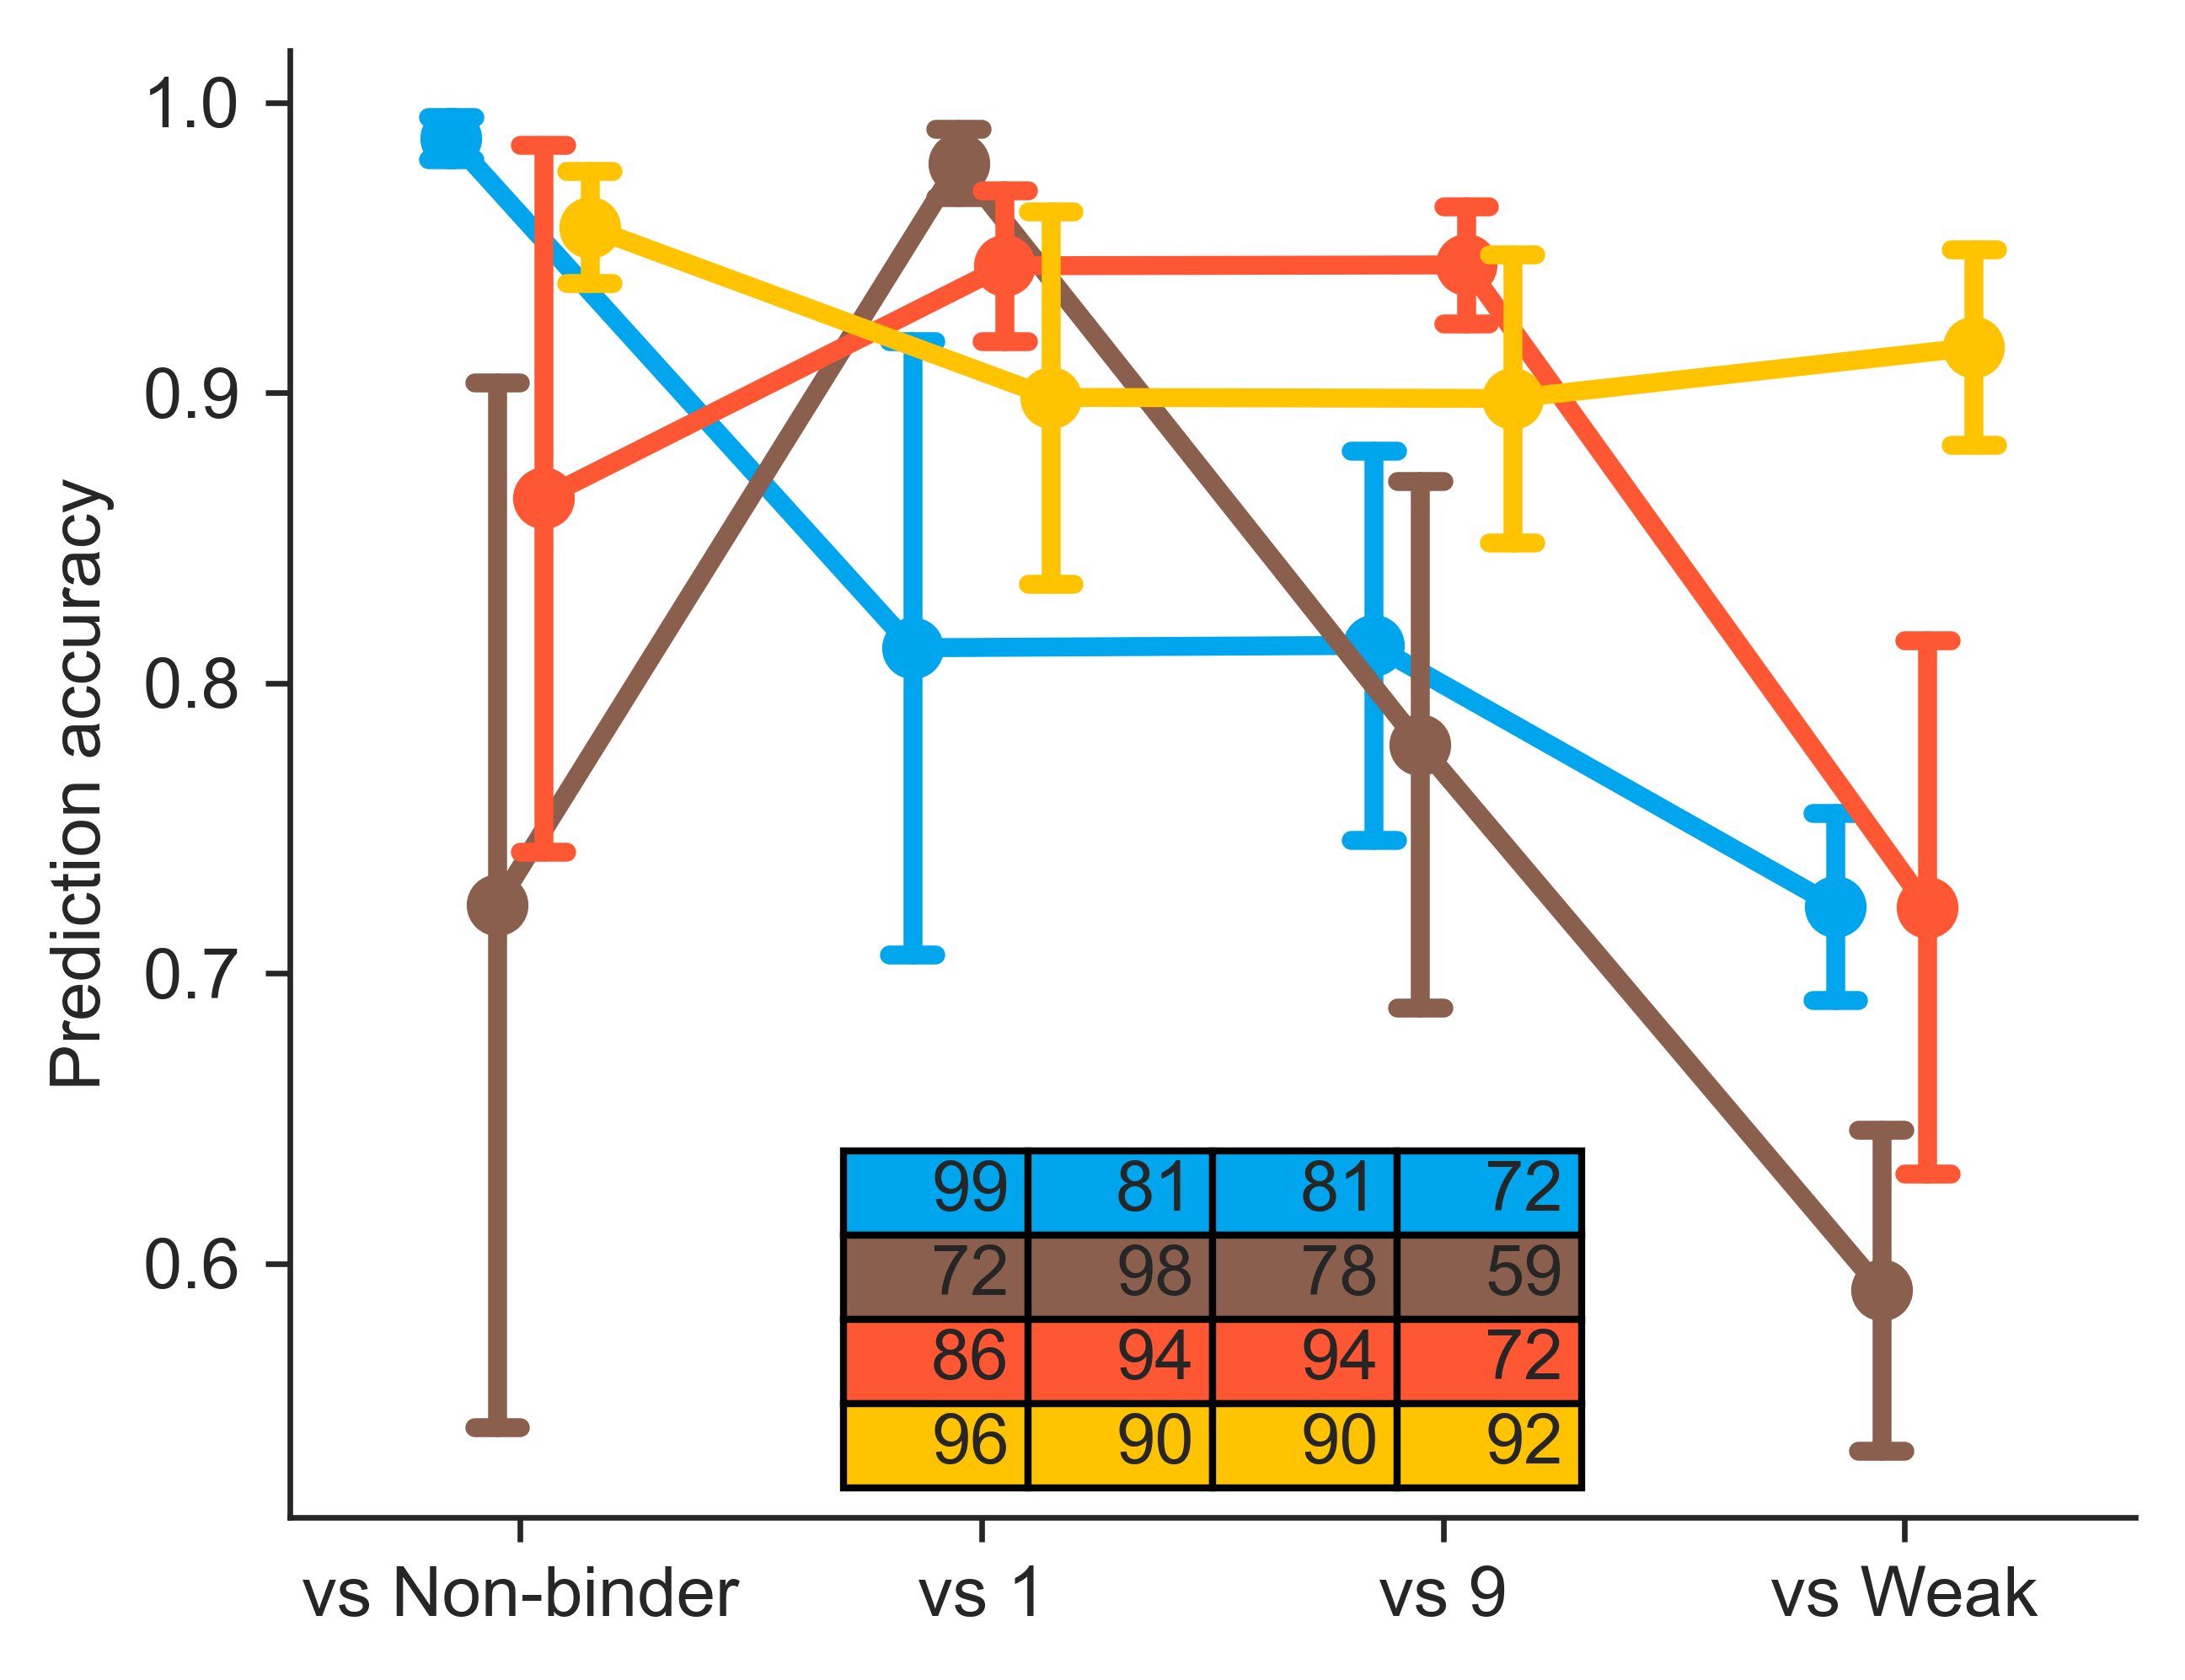

In [64]:
fig, ax = plt.subplots(figsize=(1.5* 3.14, 1.2 * 3.14), dpi=600)
sns.set_style("white")
sns.set_style('ticks')
task_order_3 = ['vs Non-binder', 'vs 1', 'vs 9', 'vs Weak']
sns.pointplot(
    perf_df,
    y="acc",
    x="test_task",
    errorbar="sd",
    order=task_order_3,
    hue="train_task",
    hue_order = task_order_3,
    palette= [cmap[task] for task in task_order_3],
    # Spread out the points a bit in horizontal
    dodge=0.3,
    ax=ax,
    capsize=0.1,
    estimator='mean'
)

# Add legend horizontally on top of plot area, outside plot area
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.15),
    ncol=3,
    fontsize=8,
    frameon=False,
    # title="Model trained on",
    # title_fontsize=8,
)

ax.set_xlabel(None)
ax.set_ylabel("Prediction accuracy")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend().set_visible(False)

#table
table_values = (perf_df.groupby(["train_task", "test_task"])["acc"].mean()\
    .reset_index().pivot(index="train_task", columns="test_task", values="acc")
    .loc[['vs Non-binder', 'vs 1', 'vs 9', 'vs Weak'], ['vs Non-binder', 'vs 1', 'vs 9', 'vs Weak']]\
    .values * 100).round().astype('int')
    #table_values = np.where(table_values == 100, "", table_values)
ax.table(
    cellText=table_values,
    loc='lower center',
    colWidths=[0.1]*4,
    cellColours=np.array([['#00A6ED', '#8B5F4D', '#FF5733', '#FFC300'] for _ in range(4)]).transpose(),
    )

fig.savefig('./figures/joined_perf_by_task.svg')

In [65]:
perf_df[(perf_df['train_task'] == 'vs 9') & (perf_df['test_task'] == 'vs 9')  & (perf_df['train_ag'] == '1ADQ')]

acc  recall  precision        f1 train_task train_ag train_neg  \
486  0.916958  0.9166   0.917334  0.916967       vs 9     1ADQ      auto   
495  0.915858  0.9082   0.922405  0.915247       vs 9     1ADQ      auto   
504  0.911556  0.9050   0.917106  0.911013       vs 9     1ADQ      auto   
513  0.915758  0.9180   0.913978  0.915985       vs 9     1ADQ      auto   
522  0.921961  0.9280   0.916996  0.922465       vs 9     1ADQ      auto   
531  0.906853  0.9082   0.905845  0.907021       vs 9     1ADQ      auto   
540  0.912456  0.9156   0.909958  0.912770       vs 9     1ADQ      auto   
549  0.919560  0.9282   0.912505  0.920286       vs 9     1ADQ      auto   
558  0.911156  0.9162   0.907129  0.911642       vs 9     1ADQ      auto   

    seed_id split_id test_task test_ag test_neg test_seed_id test_split_id  
486       0       42      vs 9    1ADQ     auto            0            42  
495       1       42      vs 9    1ADQ     auto            1            42  
504       2       42      vs 9    1ADQ     auto            2            42  
513       3       42      vs 9    1ADQ     auto            3            42  
522       0        0      vs 9    1ADQ     auto            0             0  
531       0        1      vs 9    1ADQ     auto            0             1  
540       0        2      vs 9    1ADQ     auto            0             2  
549       0        3      vs 9    1ADQ     auto            0             3  
558       0        4      vs 9    1ADQ     auto            0             4

In [66]:
perf_df.groupby(["train_task", "test_task"])["acc"].mean()\
.reset_index().pivot(index="train_task", columns="test_task", values="acc").loc[['vs Non-binder', 'vs 1', 'vs 9', 'vs Weak'], ['vs Non-binder', 'vs 1', 'vs 9', 'vs Weak']]

#.reindex(['vs Non-binder', 'vs 1', 'vs 9', 'vs Weak'], axis=1).reindex(['vs Non-binder', 'vs 1', 'vs 9', 'vs Weak'], axis=0)

test_task      vs Non-binder      vs 1      vs 9   vs Weak
train_task                                                
vs Non-binder       0.987700  0.812177  0.813005  0.723113
vs 1                0.723589  0.979155  0.778859  0.590882
vs 9                0.863709  0.943790  0.944078  0.722770
vs Weak             0.957072  0.898438  0.898077  0.915720

In [67]:
table_values = (perf_df[perf_df['train_ag'] == ag].groupby(["train_task", "test_task"])["acc"].mean()\
.reset_index().pivot(index="train_task", columns="test_task", values="acc")\
.reindex(['vs Non-binder', 'vs 1', 'vs 9', 'vs Weak'], axis=1).reindex(['vs Non-binder', 'vs 1', 'vs 9', 'vs Weak'], axis=0)\
.values * 100).round().astype('int')
#table_values = np.where(table_values == 100, "", table_values)
ax.table(
    cellText=table_values,
    loc = "lower center",
    cellColours=np.array([['#00A6ED','#8B5F4D', '#FF5733', '#FFC300'] for _ in range(4)]).transpose(),
    colWidths=[0.1]*4
)#colWidths=[0.1, 0.1, 0.1, 0.1],

In [68]:
[0.2]*4

[0.2, 0.2, 0.2, 0.2]

In [72]:
df_open_full = pd.concat([pd.read_csv('../data/1vs1_open.csv'), perf_open_df[['acc', 'recall', 'precision', 'f1', 'train_task', 'train_ag',\
       'train_neg', 'seed_id', 'split_id', 'test_task', 'test_ag', 'test_neg','test_seed_id', 'test_split_id']]],axis = 0)

In [73]:
custom_pel = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)

#sns.diverging_palette(150, 200, center = 'light', as_cmap=True)


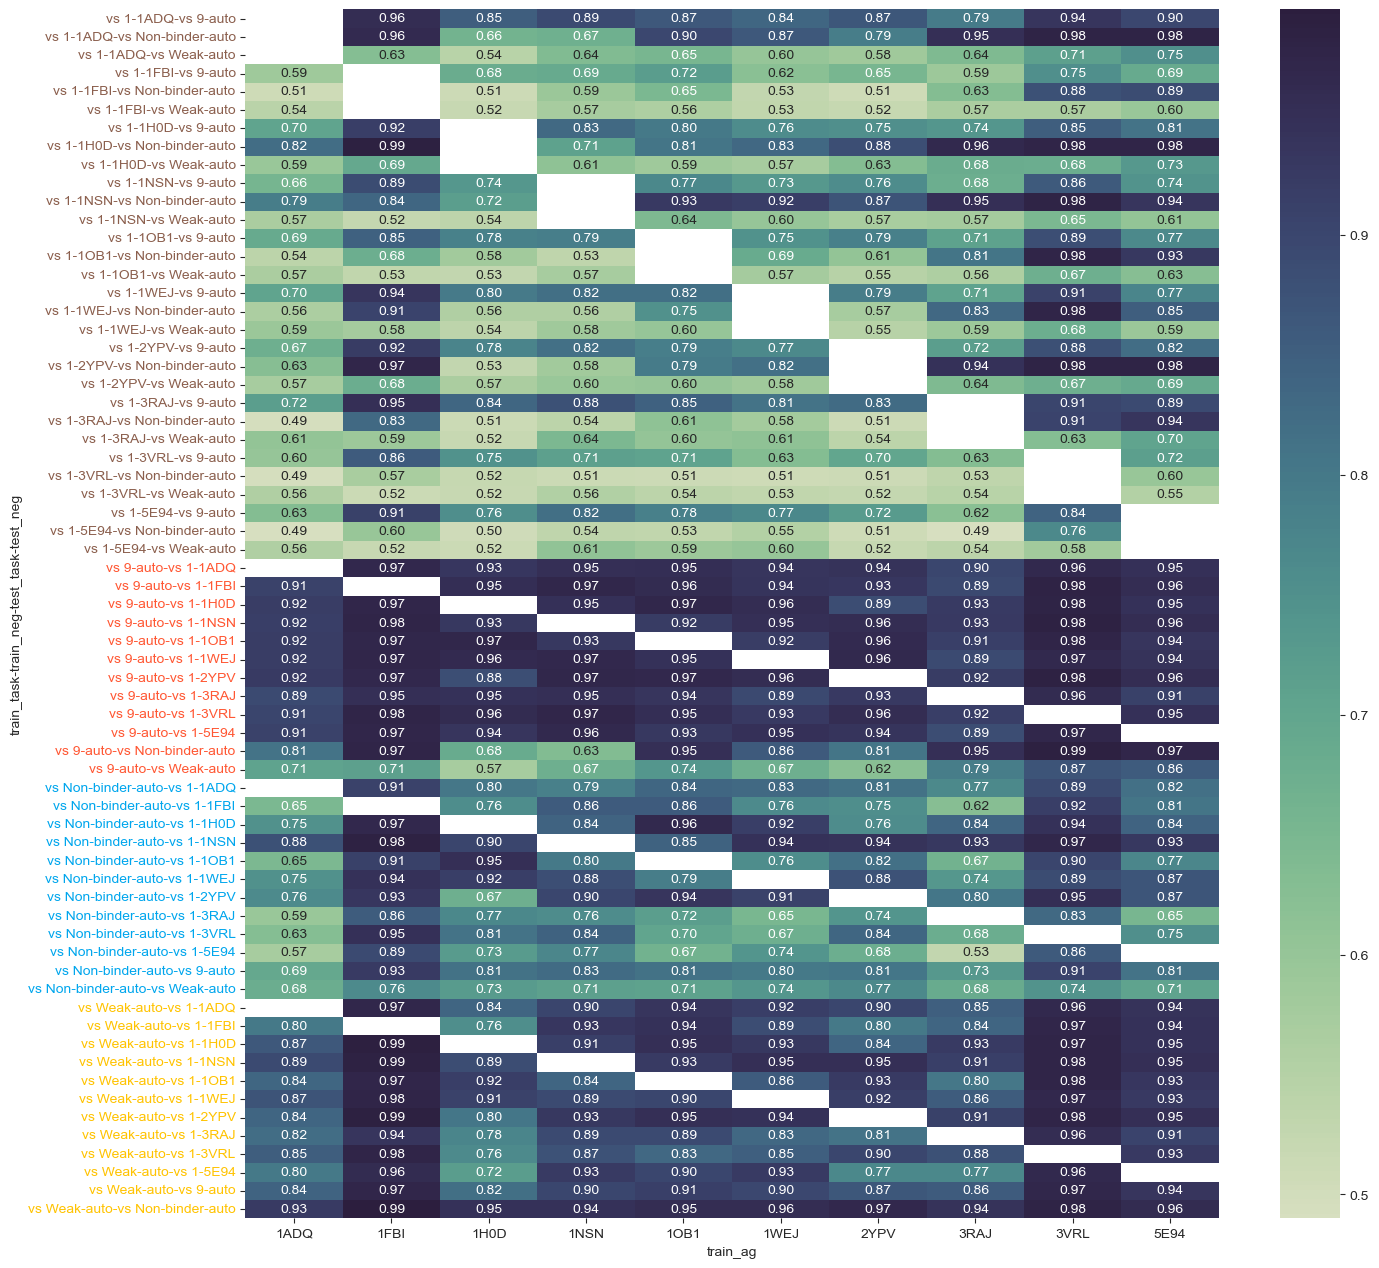

In [74]:
#remove  where train and test task "vs 1"
df_open_wo1vs1 = df_open_full[df_open_full['train_task'] != df_open_full['test_task']]
fig, ax = plt.subplots(1,1,figsize= (5 * 3.14, 5* 3.14), sharey=True, sharex=True)
sns.heatmap(df_open_wo1vs1.pivot_table(index=['train_task','train_neg','test_task','test_neg'], columns=['train_ag'], values='acc'), cmap=custom_pel, ax=ax, annot=True, fmt=".2f")
#color rowlabels by 'train_task'
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
for tick in ax.get_yticklabels():
    #get label name
    label = tick.get_text()
    label = label.split('-')[0]
    #set color
    if label == 'vs Non':
        label = 'vs Non-binder'
    tick.set_color(cmap[label])

fig.savefig('./figures/openset_performance_wo1vs1.svg')


In [47]:
cmap

{'vs 9': '#FF5733',
 'vs Non-binder': '#00A6ED',
 'vs Weak': '#FFC300',
 'vs 1': '#8B5F4D'}

In [75]:
perf_open_df[(perf_open_df['train_task'] == 'vs 1') | (perf_open_df['test_task'] == 'vs 1')]

acc  recall  precision        f1     train_task train_ag train_neg  \
0     0.857029  0.9944   0.780166  0.874352           vs 1     3VRL      1NSN   
1     0.849825  0.9946   0.771367  0.868874           vs 1     3VRL      1NSN   
2     0.856228  0.9938   0.779451  0.873670           vs 1     3VRL      1NSN   
3     0.862431  0.9936   0.787197  0.878437           vs 1     3VRL      1NSN   
4     0.876238  0.9942   0.804499  0.889346           vs 1     3VRL      1NSN   
...        ...     ...        ...       ...            ...      ...       ...   
2425  0.940700  0.9946   0.897815  0.943733  vs Non-binder     1OB1      auto   
2426  0.953800  0.9228   0.983795  0.952322        vs Weak     1OB1      auto   
2427  0.974300  0.9636   0.984672  0.974022           vs 9     1OB1      auto   
2428  0.922000  0.9958   0.867724  0.927361  vs Non-binder     1OB1      auto   
2429  0.956800  0.9318   0.980842  0.955692        vs Weak     1OB1      auto   

     seed_id split_id test_task test_ag test_neg test_seed_id test_split_id  
0          0        0      vs 9    3VRL     auto            0             0  
1          0        1      vs 9    3VRL     auto            0             1  
2          0        2      vs 9    3VRL     auto            0             2  
3          0        3      vs 9    3VRL     auto            0             3  
4          0        4      vs 9    3VRL     auto            0             4  
...      ...      ...       ...     ...      ...          ...           ...  
2425       2       42      vs 1    1OB1     2YPV          NaN           NaN  
2426       2       42      vs 1    1OB1     2YPV          NaN           NaN  
2427       3       42      vs 1    1OB1     2YPV          NaN           NaN  
2428       3       42      vs 1    1OB1     2YPV          NaN           NaN  
2429       3       42      vs 1    1OB1     2YPV          NaN           NaN  

[4860 rows x 14 columns]

In [77]:
perf_open_df.pivot_table(index=['train_task'], columns=['test_task'], values='acc', aggfunc='median')

test_task        vs 1      vs 9  vs Non-binder  vs Weak
train_task                                             
vs 1              NaN  0.780190        0.70185  0.58100
vs 9           0.9480       NaN        0.91460  0.71275
vs Non-binder  0.8236  0.813457            NaN  0.72175
vs Weak        0.9133  0.899600        0.95575      NaN

In [78]:
perf_open_df[perf_open_df['train_task'] == 'vs 1'].groupby(['train_ag', 'test_task'])['acc'].agg(['mean', 'std', 'median'])

mean       std    median
train_ag test_task                                  
1ADQ     vs 9           0.662907  0.045420  0.674337
         vs Non-binder  0.592059  0.123461  0.537900
         vs Weak        0.573386  0.020087  0.568200
1FBI     vs 9           0.909519  0.037791  0.920660
         vs Non-binder  0.815467  0.155303  0.858700
         vs Weak        0.583683  0.068134  0.571000
1H0D     vs 9           0.773782  0.050087  0.776688
         vs Non-binder  0.566414  0.072070  0.531300
         vs Weak        0.531285  0.015799  0.527000
1NSN     vs 9           0.804224  0.064290  0.818109
         vs Non-binder  0.582143  0.063795  0.561000
         vs Weak        0.598119  0.028624  0.597200
1OB1     vs 9           0.789108  0.050521  0.790495
         vs Non-binder  0.719760  0.144964  0.751100
         vs Weak        0.597206  0.034174  0.595200
1WEJ     vs 9           0.741235  0.069387  0.758379
         vs Non-binder  0.697899  0.154518  0.688000
         vs Weak        0.578494  0.028665  0.583500
2YPV     vs 9           0.762075  0.062770  0.765783
         vs Non-binder  0.640069  0.154121  0.572500
         vs Weak        0.553899  0.034153  0.544800
3RAJ     vs 9           0.687060  0.061756  0.700650
         vs Non-binder  0.789022  0.180368  0.836200
         vs Weak        0.593353  0.047949  0.575400
3VRL     vs 9           0.868892  0.051568  0.876238
         vs Non-binder  0.935115  0.071116  0.975400
         vs Weak        0.649312  0.046774  0.666600
5E94     vs 9           0.789786  0.069877  0.773987
         vs Non-binder  0.897938  0.114625  0.937100
         vs Weak        0.650084  0.067076  0.630200

In [79]:
piv_table = perf_open_df.pivot_table(index=['train_task','train_neg','test_task','test_neg'], columns=['train_ag'], values='acc')

In [80]:
perf_open_df[perf_open_df['train_task'] == 'vs Weak']['train_ag'].unique()

array(['3VRL', '1NSN', '3RAJ', '5E94', '1H0D', '1WEJ', '1ADQ', '1FBI',
       '2YPV', '1OB1'], dtype=object)

In [81]:
df_jsds['clusters'] = df_jsds.apply(lambda row: row['train_task'] + ' ' + row['train_ag'], axis=1)

JSD and open performance 

In [82]:
#changed here
jsd_dict  = dict()
for i in range(df_jsds.shape[0]):
    row = df_jsds.iloc[i]
    jsd_dict[row['train_task'], row['train_ag'],row['train_neg'],int(row['seed']), int(row['split'])] = row['jsd']

closed_acc_dict = dict()
for i in range(df_closed.shape[0]):
    row = df_closed.iloc[i]
    closed_acc_dict[row['train_task'], row['train_ag'],row['train_neg'],int(row['seed_id']), int(row['split_id'])] = row['acc']

perf_open_df['train_jsd'] = perf_open_df.apply(lambda row: jsd_dict[row['train_task'], row['train_ag'],row['train_neg'],int(row['seed_id']), int(row['split_id'])], axis=1)
perf_open_df['test_jsd'] = perf_open_df.apply(lambda row: jsd_dict[row['test_task'], row['test_ag'],row['test_neg'],int(row['seed_id']), int(row['split_id'])], axis=1)
perf_open_df['closed_acc'] = perf_open_df.apply(lambda row: closed_acc_dict[row['train_task'], row['train_ag'],row['train_neg'],int(row['seed_id']), int(row['split_id'])], axis=1)

perf_open_df['delta_jsd'] =  perf_open_df['train_jsd'] - perf_open_df['test_jsd']
perf_open_df['delta_acc'] =  perf_open_df['closed_acc'] - perf_open_df['acc']
perf_open_df.reset_index(inplace=True, drop=True)
perf_open_df['delta_jsd_norm'] = perf_open_df['delta_jsd']/perf_open_df['train_jsd']
perf_open_df['delta_acc_norm'] = perf_open_df['delta_acc']/perf_open_df['closed_acc']

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_16653/1824339883.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perf_open_df['train_jsd'] = perf_open_df.apply(lambda row: jsd_dict[row['train_task'], row['train_ag'],row['train_neg'],int(row['seed_id']), int(row['split_id'])], axis=1)
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_16653/1824339883.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perf_open_df['test_jsd'] = perf_open_df.apply(lambda row: jsd_dict[row['test_task'

In [83]:
perf_open_df.sort_values(by=['delta_jsd'])

acc  recall  precision        f1 train_task train_ag train_neg  \
4688  0.9772  0.9910   0.964383  0.977510    vs Weak     1FBI      auto   
4691  0.9749  0.9894   0.961516  0.975259    vs Weak     1FBI      auto   
4694  0.9775  0.9906   0.965309  0.977791    vs Weak     1FBI      auto   
4697  0.9749  0.9884   0.962415  0.975234    vs Weak     1FBI      auto   
4685  0.9773  0.9920   0.963668  0.977629    vs Weak     1FBI      auto   
...      ...     ...        ...       ...        ...      ...       ...   
2493  0.5148  0.9922   0.507571  0.671585       vs 1     1FBI      3VRL   
2501  0.5145  0.9958   0.507388  0.672247       vs 1     1FBI      3VRL   
2497  0.5152  0.9956   0.507752  0.672521       vs 1     1FBI      3VRL   
2499  0.5153  0.9958   0.507802  0.672611       vs 1     1FBI      3VRL   
2495  0.5153  0.9952   0.507807  0.672478       vs 1     1FBI      3VRL   

     seed_id split_id test_task  ... test_neg test_seed_id test_split_id  \
4688       0       42      vs 1  ...     3VRL          NaN           NaN   
4691       1       42      vs 1  ...     3VRL          NaN           NaN   
4694       2       42      vs 1  ...     3VRL          NaN           NaN   
4697       3       42      vs 1  ...     3VRL          NaN           NaN   
4685       0        4      vs 1  ...     3VRL          NaN           NaN   
...      ...      ...       ...  ...      ...          ...           ...   
2493       0        4   vs Weak  ...     auto            0             4   
2501       3       42   vs Weak  ...     auto            3            42   
2497       1       42   vs Weak  ...     auto            1            42   
2499       2       42   vs Weak  ...     auto            2            42   
2495       0       42   vs Weak  ...     auto            0            42   

     train_jsd  test_jsd  closed_acc  delta_jsd  delta_acc  delta_jsd_norm  \
4688  1.263349  5.067362      0.9750  -3.804013    -0.0022       -3.011055   
4691  1.263349  5.067362      0.9754  -3.804013     0.0005       -3.011055   
4694  1.263349  5.067362      0.9763  -3.804013    -0.0012       -3.011055   
4697  1.263349  5.067362      0.9744  -3.804013    -0.0005       -3.011055   
4685  1.251853  5.054408      0.9747  -3.802555    -0.0026       -3.037540   
...        ...       ...         ...        ...        ...             ...   
2493  5.054408  1.251853      0.9941   3.802555     0.4793        0.752324   
2501  5.067362  1.263349      0.9952   3.804013     0.4807        0.750689   
2497  5.067362  1.263349      0.9947   3.804013     0.4795        0.750689   
2499  5.067362  1.263349      0.9951   3.804013     0.4798        0.750689   
2495  5.067362  1.263349      0.9951   3.804013     0.4798        0.750689   

      delta_acc_norm  
4688       -0.002256  
4691        0.000513  
4694       -0.001229  
4697       -0.000513  
4685       -0.002667  
...              ...  
2493        0.482145  
2501        0.483018  
2497        0.482055  
2499        0.482163  
2495        0.482163  

[5400 rows x 21 columns]

In [84]:
#df_jsds['dupl_filter'] = df_jsds.apply(lambda row: '_'.join(set(row[['train_ag','train_neg']])) + '_' + row['train_task'], axis=1)
#perf_open_df['dupl_filter'] = perf_open_df.apply(lambda row: '_'.join(set(row[['train_ag','train_neg']])) + '_' + '_'.join(row[['train_task','test_task']].values) + '_' + '_'.join(set(row[['test_ag', 'test_neg']])), axis=1)

In [85]:
perf_open_df['dupl_filter'] = perf_open_df.apply(lambda row: '_'.join(row[['train_ag','train_neg']]) + '_' + '_'.join(row[['train_task','test_task']].values) + '_' + '_'.join(set(row[['test_ag', 'test_neg']])), axis=1)

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_16653/2423526725.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perf_open_df['dupl_filter'] = perf_open_df.apply(lambda row: '_'.join(row[['train_ag','train_neg']]) + '_' + '_'.join(row[['train_task','test_task']].values) + '_' + '_'.join(set(row[['test_ag', 'test_neg']])), axis=1)


In [86]:
perf_open_df['dupl_filter']

0          3VRL_auto_vs 9_vs Non-binder_auto_3VRL
1                3VRL_auto_vs 9_vs Weak_auto_3VRL
2          3VRL_auto_vs Non-binder_vs 9_auto_3VRL
3       3VRL_auto_vs Non-binder_vs Weak_auto_3VRL
4                3VRL_auto_vs Weak_vs 9_auto_3VRL
                          ...                    
5395       1OB1_auto_vs Non-binder_vs 1_2YPV_1OB1
5396             1OB1_auto_vs Weak_vs 1_2YPV_1OB1
5397                1OB1_auto_vs 9_vs 1_2YPV_1OB1
5398       1OB1_auto_vs Non-binder_vs 1_2YPV_1OB1
5399             1OB1_auto_vs Weak_vs 1_2YPV_1OB1
Name: dupl_filter, Length: 5400, dtype: object

In [87]:
perf_open_df_mean = perf_open_df.groupby(['dupl_filter']).mean()

In [88]:
pd.DataFrame(list(perf_open_df_mean.index.str.split('_', expand=True)))

0     1        2              3     4     5
0    1ADQ  1FBI     vs 1           vs 9  auto  1ADQ
1    1ADQ  1FBI     vs 1  vs Non-binder  auto  1ADQ
2    1ADQ  1FBI     vs 1        vs Weak  auto  1ADQ
3    1ADQ  1H0D     vs 1           vs 9  auto  1ADQ
4    1ADQ  1H0D     vs 1  vs Non-binder  auto  1ADQ
..    ...   ...      ...            ...   ...   ...
595  5E94  auto  vs Weak           vs 1  5E94  2YPV
596  5E94  auto  vs Weak           vs 1  5E94  3RAJ
597  5E94  auto  vs Weak           vs 1  5E94  3VRL
598  5E94  auto  vs Weak           vs 9  5E94  auto
599  5E94  auto  vs Weak  vs Non-binder  5E94  auto

[600 rows x 6 columns]

In [89]:
perf_open_df_mean[['train_ag','train_neg','train_task','test_task', 'test_ag', 'test_neg']] = list(perf_open_df_mean.index.str.split('_', expand=True))

In [90]:
perf_open_df_mean.reset_index(inplace=True, drop=True)

In [91]:
perf_open_df_mean

acc    recall  precision        f1  train_jsd  test_jsd  closed_acc  \
0    0.586571  0.976867   0.548753  0.702739   3.876653  1.978896    0.981289   
1    0.509411  0.976867   0.504865  0.665688   3.876653  3.120453    0.981289   
2    0.541511  0.976867   0.522192  0.680575   3.876653  1.337161    0.981289   
3    0.704252  0.973444   0.633256  0.767213   3.209987  1.978896    0.976556   
4    0.821678  0.973444   0.749492  0.846121   3.209987  3.120453    0.976556   
..        ...       ...        ...       ...        ...       ...         ...   
595  0.949978  0.919889   0.978803  0.948417   1.641843  2.970038    0.922411   
596  0.907022  0.919889   0.896895  0.908210   1.641843  2.918428    0.922411   
597  0.928144  0.919889   0.935408  0.927551   1.641843  4.925170    0.922411   
598  0.936157  0.919889   0.950921  0.935127   1.641843  2.873144    0.922411   
599  0.959544  0.919889   0.999131  0.957863   1.641843  3.529951    0.922411   

     delta_jsd  delta_acc  delta_jsd_norm  delta_acc_norm train_ag train_neg  \
0     1.897757   0.394718        0.489540        0.402245     1ADQ      1FBI   
1     0.756200   0.471878        0.195063        0.480876     1ADQ      1FBI   
2     2.539492   0.439778        0.655092        0.448163     1ADQ      1FBI   
3     1.231091   0.272303        0.383523        0.278810     1ADQ      1H0D   
4     0.089534   0.154878        0.027897        0.158512     1ADQ      1H0D   
..         ...        ...             ...             ...      ...       ...   
595  -1.328195  -0.027567       -0.809348       -0.029887     5E94      auto   
596  -1.276585   0.015389       -0.778042        0.016682     5E94      auto   
597  -3.283327  -0.005733       -2.000501       -0.006221     5E94      auto   
598  -1.231300  -0.013746       -0.750416       -0.014905     5E94      auto   
599  -1.888107  -0.037133       -1.150482       -0.040258     5E94      auto   

    train_task      test_task test_ag test_neg  
0         vs 1           vs 9    auto     1ADQ  
1         vs 1  vs Non-binder    auto     1ADQ  
2         vs 1        vs Weak    auto     1ADQ  
3         vs 1           vs 9    auto     1ADQ  
4         vs 1  vs Non-binder    auto     1ADQ  
..         ...            ...     ...      ...  
595    vs Weak           vs 1    5E94     2YPV  
596    vs Weak           vs 1    5E94     3RAJ  
597    vs Weak           vs 1    5E94     3VRL  
598    vs Weak           vs 9    5E94     auto  
599    vs Weak  vs Non-binder    5E94     auto  

[600 rows x 17 columns]

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_16653/1502556074.py:64: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


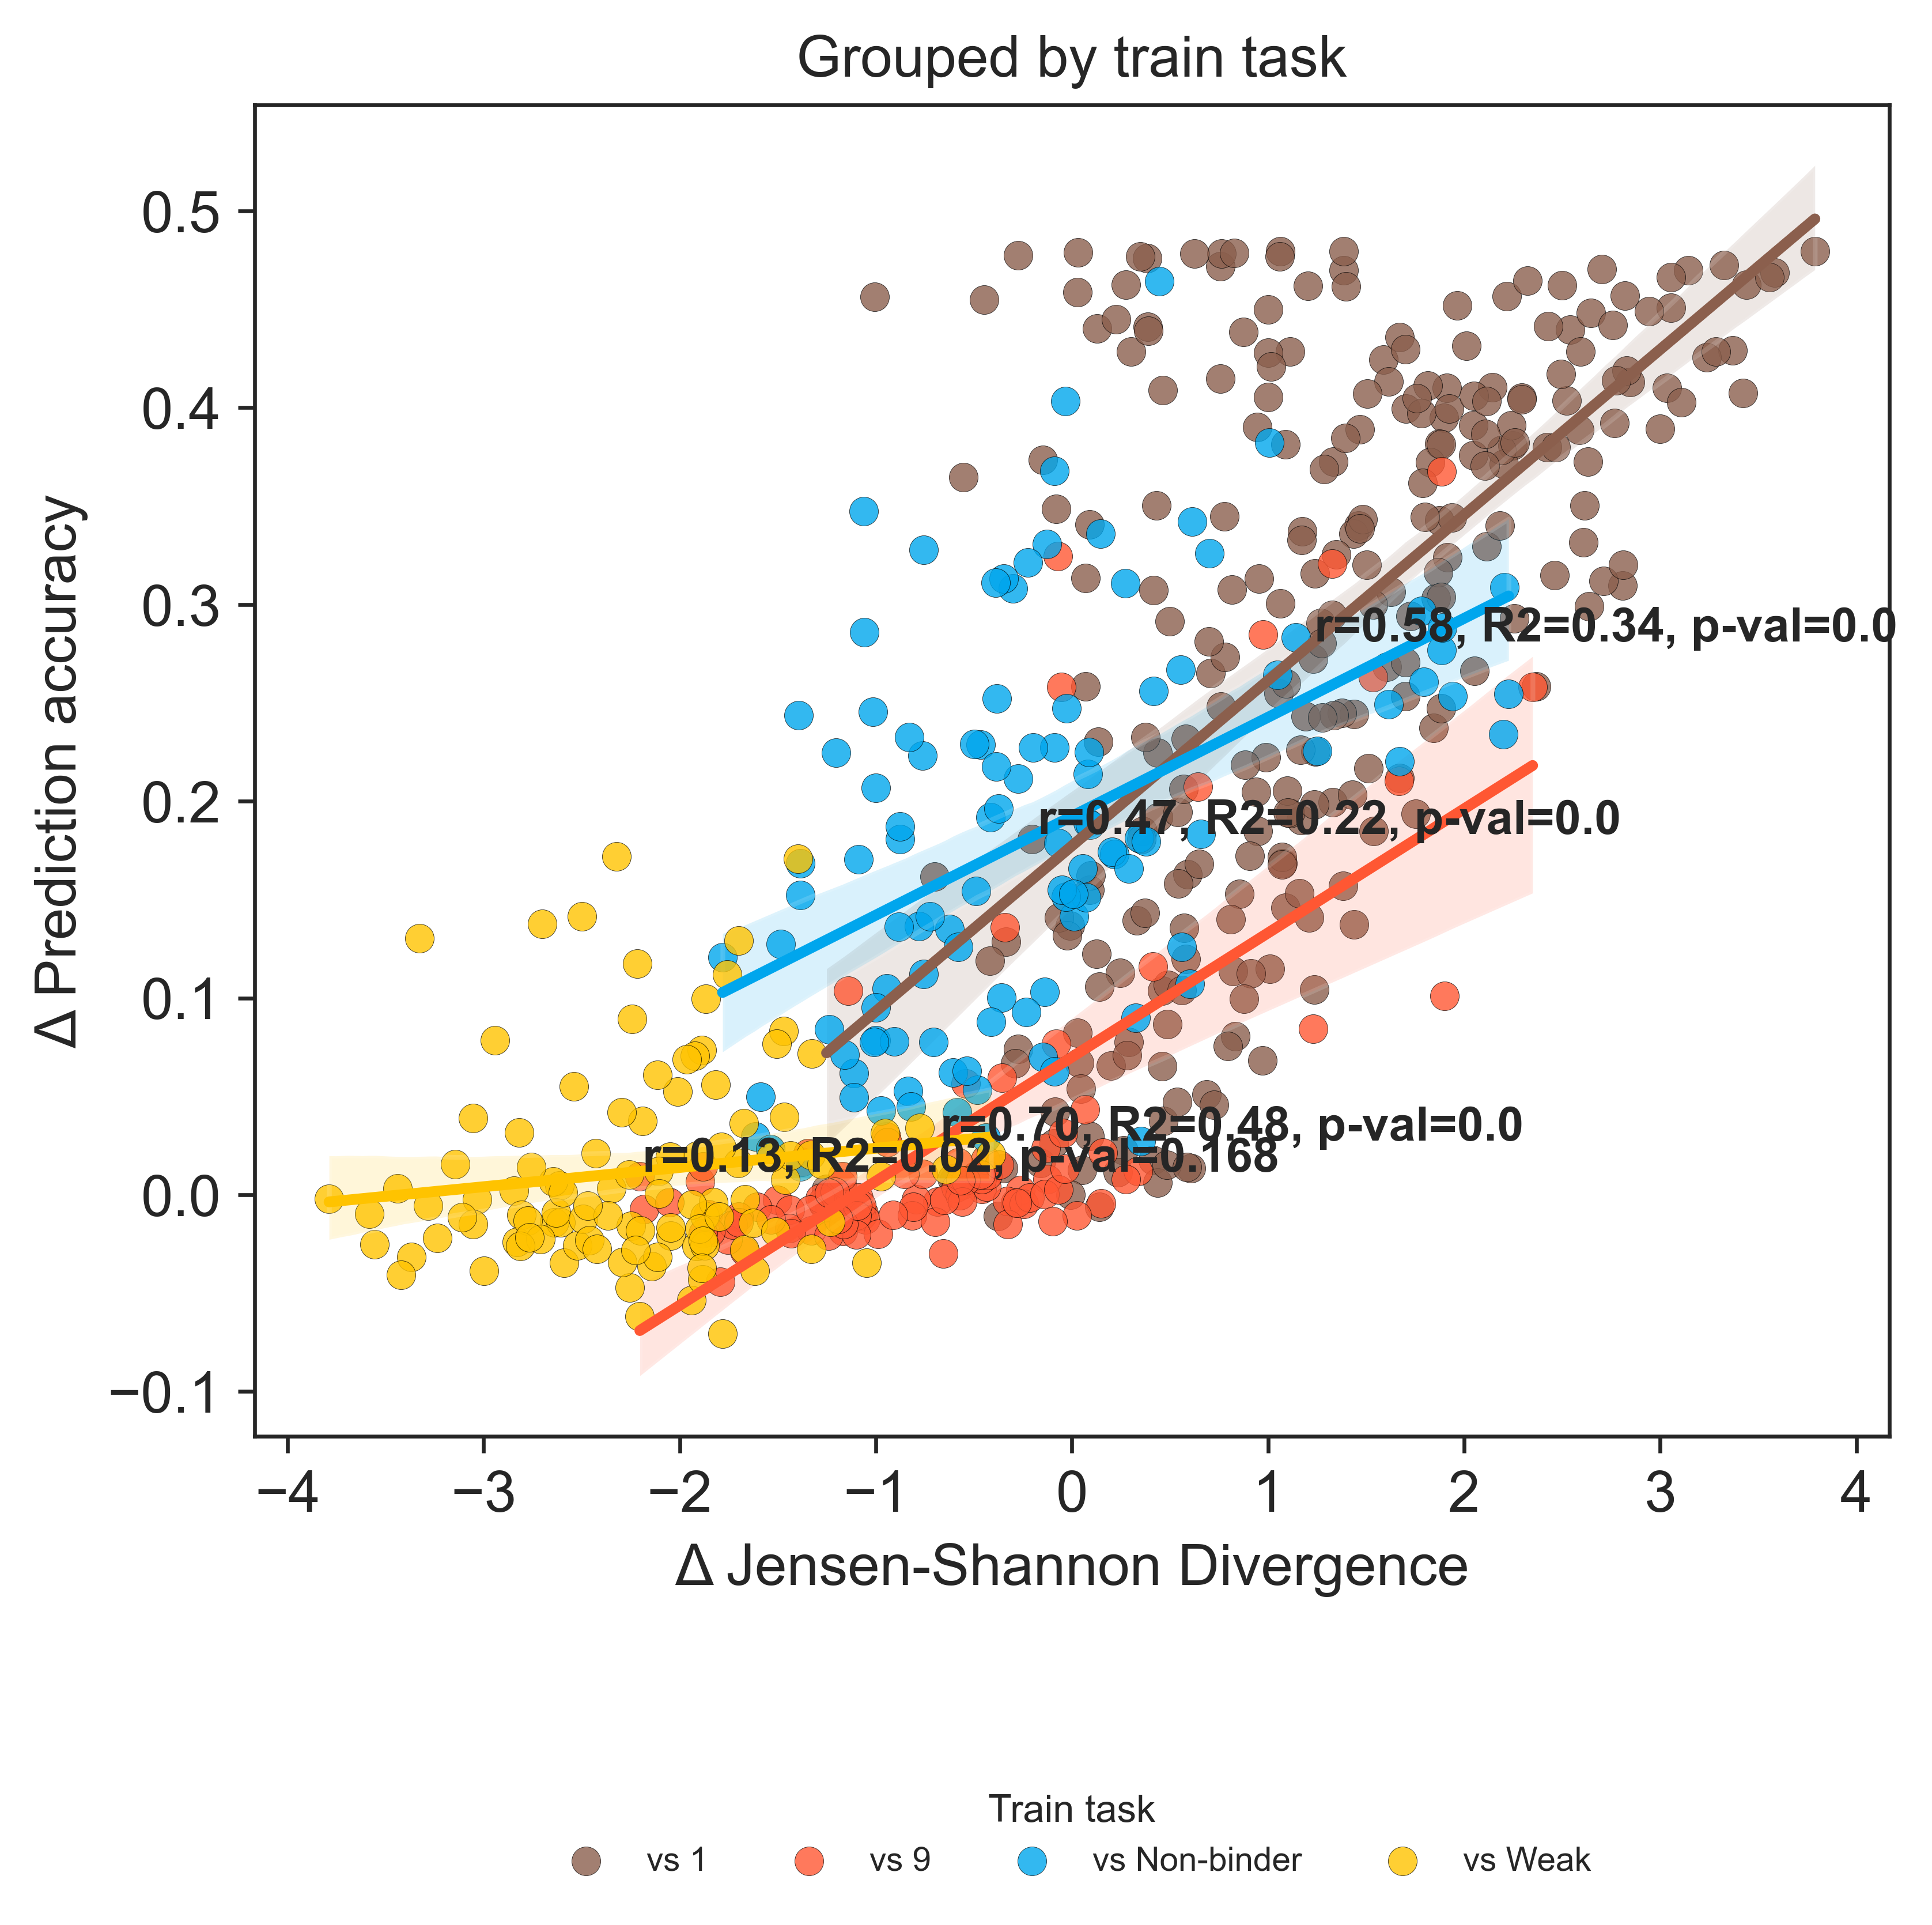

In [92]:
#matters how I calculate delta

cmap = { 'vs 9' : '#FF5733',
         'vs Non-binder':'#00A6ED',
         'vs Weak':'#FFC300',
         'vs 1': '#8B5F4D'}
marker_styles = { 'vs 9' : 'o',
         'vs Non-binder':'^',
         'vs Weak':'X',
         'vs 1': '8'}

sns.set_style("white")
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(5*1.22, 5), dpi=600)

# Line plot in seaborn with R2 regression
for task, df_g in perf_open_df_mean.groupby("train_task"):
    sns.regplot(
        y="delta_acc",
        x="delta_jsd",
        data=df_g,
        scatter=True,
        ax=ax,
        label=task,
        color=cmap[task],
        scatter_kws={'edgecolor': 'black', 'linewidth': 0.1} 

    )

    # Compute Pearson correlation
    r, pval = pearsonr(df_g["delta_jsd"], df_g["delta_acc"])
    # Add text with r and R2 at centroid
    x = df_g["delta_jsd"].mean()
    y = df_g["delta_acc"].mean()
    ax.text(x, y, f"r={r:.2f}, R2={r**2:.2f}, p-val={pval.round(3)}", fontsize=10, fontweight="bold")

FONT_SIZE = 12
ax.tick_params(labelsize=FONT_SIZE)
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Task",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)
ax.set_xlabel("Δ Jensen-Shannon Divergence", fontsize=FONT_SIZE)
ax.set_ylabel("Δ Prediction accuracy", fontsize=FONT_SIZE)
#yticks = np.arange(0.85, 1.0, 0.05)
#ax.set_yticks(yticks)

# Title
# ax.set_title("Relationship beteen SN10 accuracy and Jensen-Shannon Divergence (JSD)", fontsize=FONT_SIZE)


# put legend to the bottom
ax.legend(bbox_to_anchor=(0.5, -0.3), loc="center", borderaxespad=0.0, fontsize=7, title="Train task", title_fontsize=8, ncol=10, frameon=False)
#remove legend
#ax.get_legend().remove()
ax.set_title('Grouped by train task')

fig.show()
#fig.savefig('./figures/delta_jsd_vs_delta_acc_sq.svg')

In [98]:
perf_open_df_mean[perf_open_df_mean['train_task'] == 'vs 1']

acc    recall  precision        f1  train_jsd  test_jsd  closed_acc  \
0    0.586571  0.976867   0.548753  0.702739   3.876653  1.978896    0.981289   
1    0.509411  0.976867   0.504865  0.665688   3.876653  3.120453    0.981289   
2    0.541511  0.976867   0.522192  0.680575   3.876653  1.337161    0.981289   
3    0.704252  0.973444   0.633256  0.767213   3.209987  1.978896    0.976556   
4    0.821678  0.973444   0.749492  0.846121   3.209987  3.120453    0.976556   
..        ...       ...        ...       ...        ...       ...         ...   
562  0.937644  0.936756   0.938501  0.937603   2.918428  3.529951    0.945900   
563  0.703522  0.936756   0.638825  0.759603   2.918428  1.641843    0.945900   
564  0.716169  0.980156   0.641708  0.775571   4.925170  2.873144    0.982344   
565  0.597789  0.980156   0.555563  0.709104   4.925170  3.529951    0.982344   
566  0.553944  0.980156   0.529125  0.687242   4.925170  1.641843    0.982344   

     delta_jsd  delta_acc  delta_jsd_norm  delta_acc_norm train_ag train_neg  \
0     1.897757   0.394718        0.489540        0.402245     1ADQ      1FBI   
1     0.756200   0.471878        0.195063        0.480876     1ADQ      1FBI   
2     2.539492   0.439778        0.655092        0.448163     1ADQ      1FBI   
3     1.231091   0.272303        0.383523        0.278810     1ADQ      1H0D   
4     0.089534   0.154878        0.027897        0.158512     1ADQ      1H0D   
..         ...        ...             ...             ...      ...       ...   
562  -0.611522   0.008256       -0.209632        0.008724     5E94      3RAJ   
563   1.276585   0.242378        0.437387        0.256235     5E94      3RAJ   
564   2.052027   0.266175        0.416624        0.270938     5E94      3VRL   
565   1.395220   0.384556        0.283277        0.391436     5E94      3VRL   
566   3.283327   0.428400        0.666656        0.436096     5E94      3VRL   

    train_task      test_task test_ag test_neg  
0         vs 1           vs 9    auto     1ADQ  
1         vs 1  vs Non-binder    auto     1ADQ  
2         vs 1        vs Weak    auto     1ADQ  
3         vs 1           vs 9    auto     1ADQ  
4         vs 1  vs Non-binder    auto     1ADQ  
..         ...            ...     ...      ...  
562       vs 1  vs Non-binder    5E94     auto  
563       vs 1        vs Weak    5E94     auto  
564       vs 1           vs 9    5E94     auto  
565       vs 1  vs Non-binder    5E94     auto  
566       vs 1        vs Weak    5E94     auto  

[270 rows x 17 columns]

In [93]:
perf_open_df_mean_wo_1 = perf_open_df_mean[(perf_open_df_mean['test_task'] != 'vs 1') & (perf_open_df_mean['train_task'] != 'vs 1')]

<AxesSubplot:xlabel='delta_jsd', ylabel='delta_acc'>

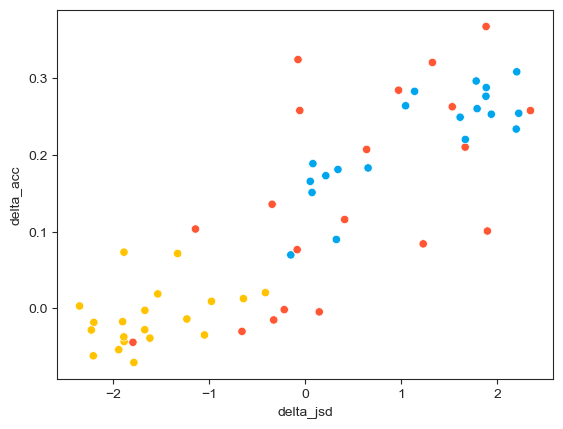

In [191]:
perf_open_df_mean_wo_1 = perf_open_df_mean[(perf_open_df_mean['test_task'] != 'vs 1') & (perf_open_df_mean['train_task'] != 'vs 1')]

sns.scatterplot(
        x="delta_jsd",
        y="delta_acc",
        data=perf_open_df_mean_wo_1,
        hue='train_task',
        palette=cmap,
        legend=False
    )

In [ ]:

sns.scatterplot(
        x="delta_jsd",
        y="delta_acc",
        data=perf_open_df_mean,
        hue='train_task',
        palette=cmap,
        legend=False
    )

In [166]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Sample data

X = perf_open_df_mean["delta_jsd"].values.reshape(-1, 1)
y = perf_open_df_mean["delta_acc"].values.reshape(-1, 1)
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create polynomial features
degree = 3
poly = PolynomialFeatures(degree)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Fit a linear regression model
model = LinearRegression().fit(X_train_poly, y_train)

# Predict
y_pred = model.predict(X_test_poly)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.008252407915818471


In [167]:
model.coef_

array([[ 0.        ,  0.09522425,  0.00600869, -0.00271145]])

In [168]:
len(X_test_poly.squeeze())

120

<AxesSubplot:>

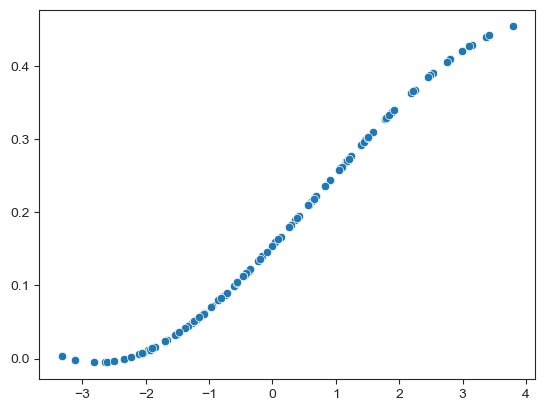

In [169]:
sns.scatterplot(x=X_test.reshape(1,-1).squeeze(), y=y_pred.reshape(1,-1).squeeze())

<AxesSubplot:>

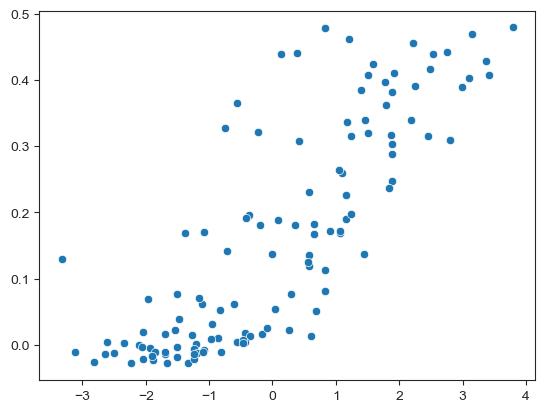

In [140]:
sns.scatterplot(x=X_test.reshape(1,-1).squeeze(), y=y_test.reshape(1,-1).squeeze())

In [180]:
from sklearn.preprocessing import StandardScaler
scale_x = StandardScaler()
scale_y = StandardScaler()
X_train_scaled = scale_x.fit_transform(X_train)
y_train_scaled = scale_y.fit_transform(y_train)
X_test_scaled = scale_x.transform(X_test)
y_test_scaled = scale_y.transform(y_test)

degree = 3
poly = PolynomialFeatures(degree)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Fit a linear regression model
model = LinearRegression().fit(X_train_poly, y_train_scaled)

# Predict
y_pred = model.predict(X_test_poly)

# Evaluate
mse = mean_squared_error(y_test_scaled, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.311122380966153


<AxesSubplot:>

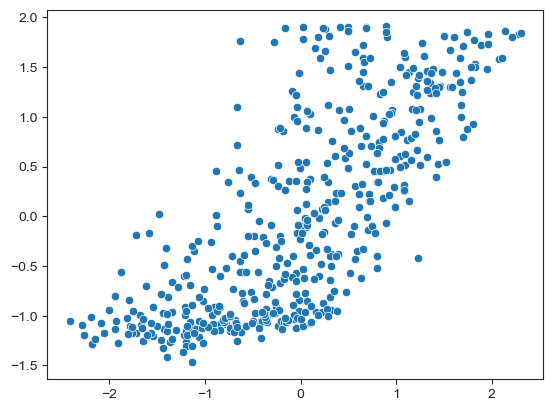

In [181]:
sns.scatterplot(x=X_train_scaled.reshape(1,-1).squeeze(), y=y_train_scaled.reshape(1,-1).squeeze())

<AxesSubplot:>

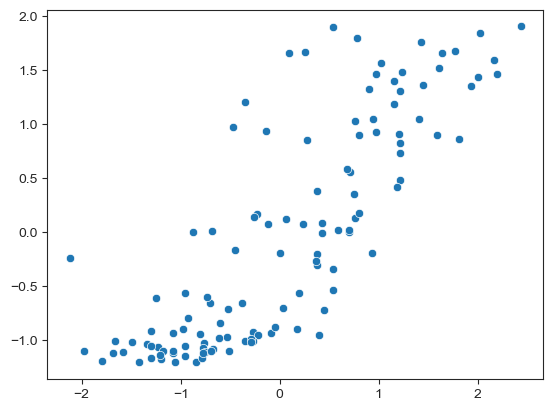

In [182]:
sns.scatterplot(x=X_test_scaled.reshape(1,-1).squeeze(), y=y_test_scaled.reshape(1,-1).squeeze())

<AxesSubplot:>

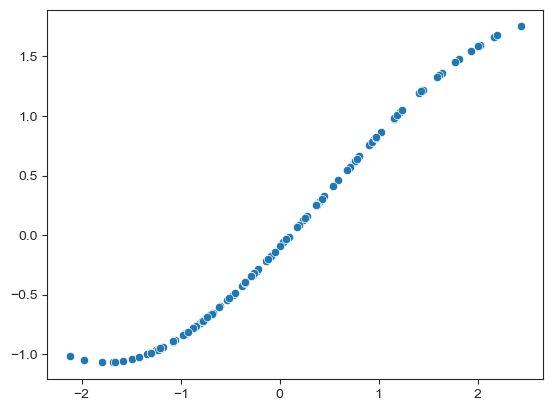

In [183]:
sns.scatterplot(x=X_test_scaled.reshape(1,-1).squeeze(), y=y_pred.reshape(1,-1).squeeze())

In [48]:
perf_open_df_mean.groupby("train_task").count()

acc  recall  precision   f1  train_jsd  test_jsd  closed_acc  \
train_task                                                                    
vs 1           270     270        270  270        270       270         270   
vs 9           110     110        110  110        110       110         110   
vs Non-binder  110     110        110  110        110       110         110   
vs Weak        110     110        110  110        110       110         110   

               delta_jsd  delta_acc  delta_jsd_norm  delta_acc_norm  train_ag  \
train_task                                                                      
vs 1                 270        270             270             270       270   
vs 9                 110        110             110             110       110   
vs Non-binder        110        110             110             110       110   
vs Weak              110        110             110             110       110   

               train_neg  test_task  test_ag  test_neg  
train_task                                              
vs 1                 270        270      270       270  
vs 9                 110        110      110       110  
vs Non-binder        110        110      110       110  
vs Weak              110        110      110       110

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_1716/2969194274.py:60: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


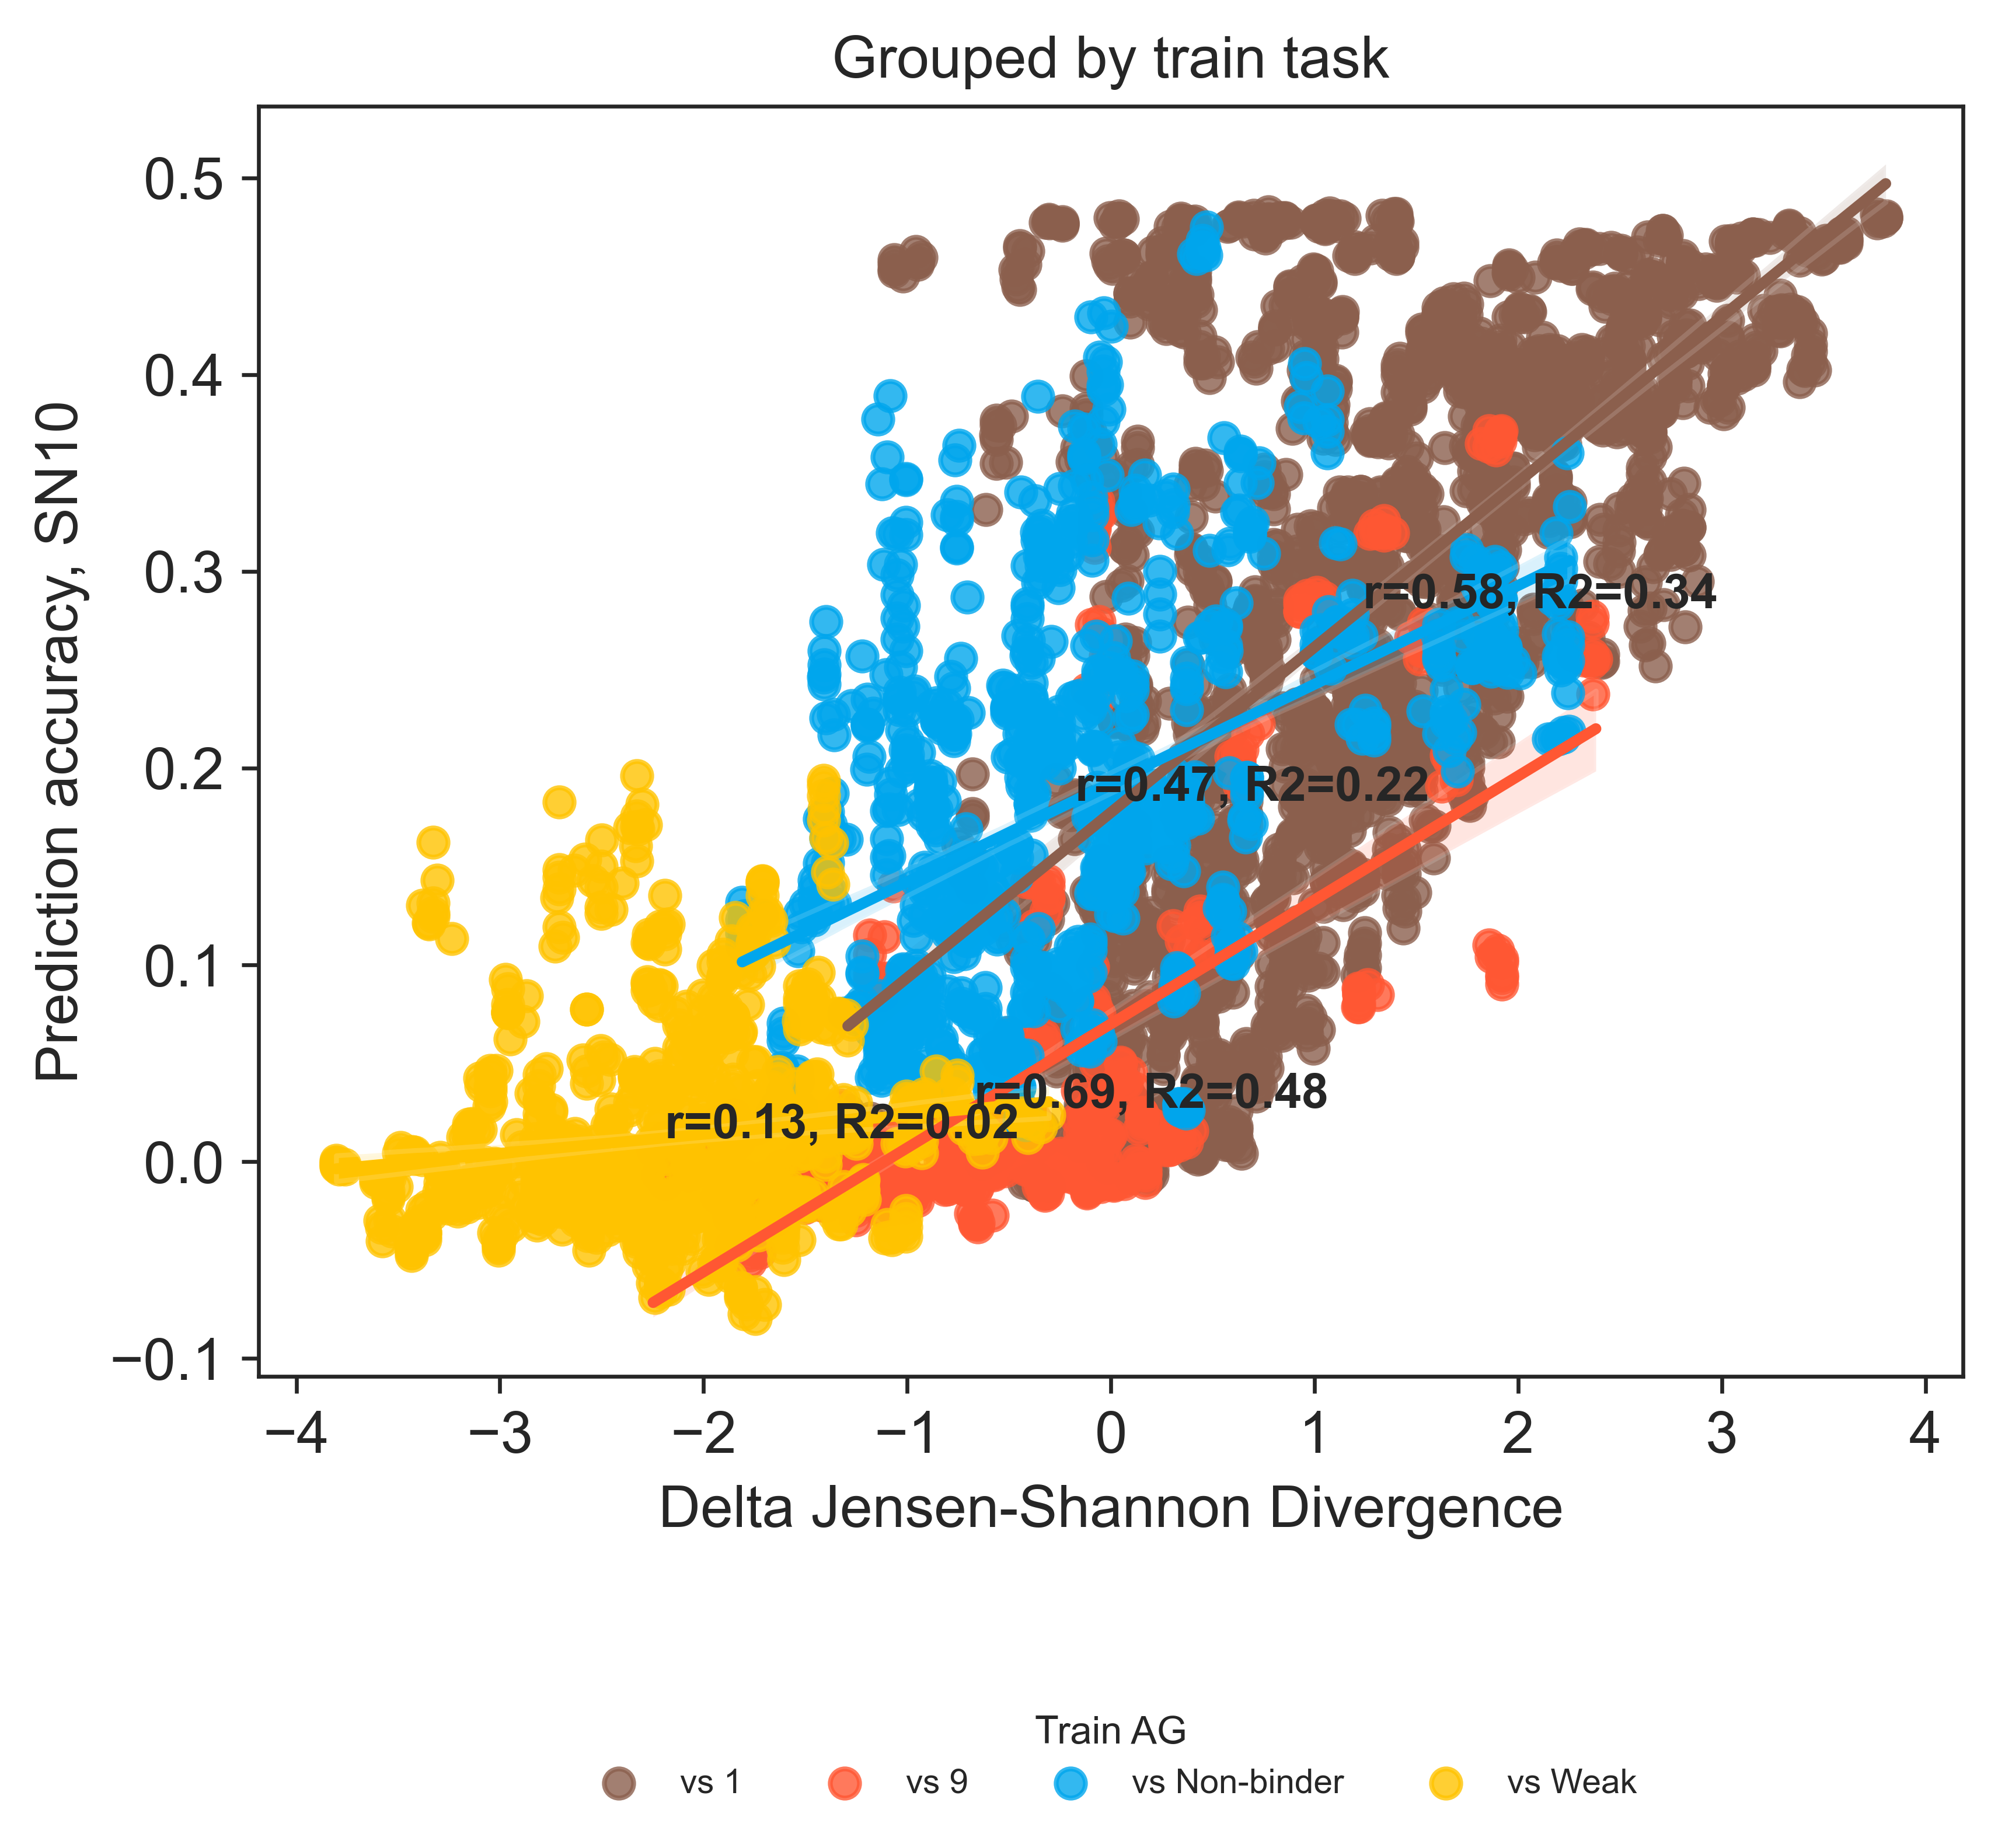

In [314]:
cmap = { 'vs 9' : '#FF5733',
         'vs Non-binder':'#00A6ED',
         'vs Weak':'#FFC300',
         'vs 1': '#8B5F4D'}
marker_styles = { 'vs 9' : 'o',
         'vs Non-binder':'^',
         'vs Weak':'X',
         'vs 1': '8'}

sns.set_style("white")
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(2*3.14, 1.5*3.14), dpi=600)

# Line plot in seaborn with R2 regression
for task, df_g in perf_open_df.groupby("train_task"):
    sns.regplot(
        x="delta_jsd",
        y="delta_acc",
        data=df_g,
        scatter=True,
        ax=ax,
        label=task,
        color=cmap[task],
    )

    # Compute Pearson correlation
    r, pval = pearsonr(df_g["delta_jsd"], df_g["delta_acc"])
    # Add text with r and R2 at centroid
    x = df_g["delta_jsd"].mean()
    y = df_g["delta_acc"].mean()
    ax.text(x, y, f"r={r:.2f}, R2={r**2:.2f}", fontsize=10, fontweight="bold")

FONT_SIZE = 12
ax.tick_params(labelsize=FONT_SIZE)
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Task",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)
ax.set_xlabel("Delta Jensen-Shannon Divergence", fontsize=FONT_SIZE)
ax.set_ylabel(yaxis_title, fontsize=FONT_SIZE)
#yticks = np.arange(0.85, 1.0, 0.05)
#ax.set_yticks(yticks)

# Title
# ax.set_title("Relationship beteen SN10 accuracy and Jensen-Shannon Divergence (JSD)", fontsize=FONT_SIZE)


# put legend to the bottom
ax.legend(bbox_to_anchor=(0.5, -0.3), loc="center", borderaxespad=0.0, fontsize=7, title="Train AG", title_fontsize=8, ncol=10, frameon=False)
#remove legend
#ax.get_legend().remove()
ax.set_title('Grouped by train task')

fig.show()
fig.savefig('./figures/delta_jsd_vs_delta_acc_sq.svg')

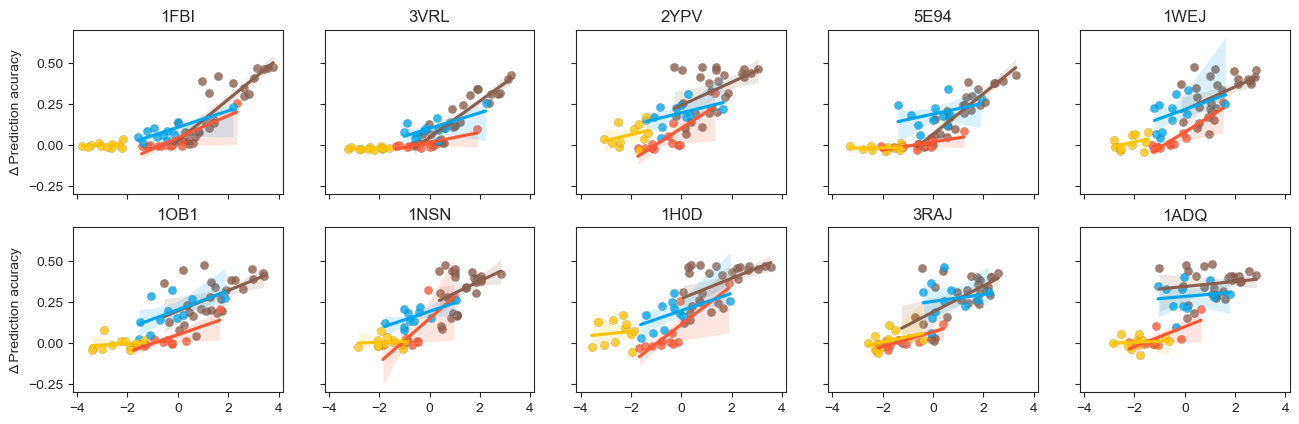

In [81]:
#open performance
plt.rcParams['svg.fonttype'] = 'none'
sns.set_style("white")
sns.set_style('ticks')

fig, ax = plt.subplots(2,5,figsize= (5 * 3.14, 1.5 * 3.14), sharey=True, sharex=True)
# set font size
for i, ag in enumerate(ag_order):
    r = i //5
    c = i % 5
    df = perf_open_df_mean[perf_open_df_mean['train_ag'] == ag]
    ax_=ax[r,c]

# Line plot in seaborn with R2 regression
    for task, df_g in df.groupby("train_task"):
        sns.regplot(
            x="delta_jsd",
            y="delta_acc",
            data=df_g,
            scatter=True,
            ax=ax_,
            color=cmap[task],
            scatter_kws={'edgecolor': 'black', 'linewidth': 0.1}
        )

        # Compute Pearson correlation
        r, pval = pearsonr(df_g["delta_jsd"], df_g["delta_acc"])
        # Add text with r and R2 at centroid
        x = df_g["delta_jsd"].mean()
        y = df_g["delta_acc"].mean()
        r, pval = pearsonr(df_g["delta_jsd"], df_g["delta_acc"])
        #ax_.text(x, y, f"r={r:.2f}, R2={r**2:.2f}", fontsize=8, fontweight="bold")

        ax_.set_title(ag, fontsize=12)
        if c!=0:
            ax_.set_ylabel('')
        else:
            ax_.set_ylabel('Δ Prediction acuracy')
        #remove xlabel
        ax_.set_xlabel('')

#save
fig.savefig('./figures/delta_jsd_vs_delta_acc_by_ag.svg')




In [223]:
import scipy

In [246]:
for i, ag in enumerate(ag_order):
    r = i //5
    c = i % 5
    df = perf_open_df_mean[perf_open_df_mean['train_ag'] == ag]

# Line plot in seaborn with R2 regression
    for task, df_g in df.groupby("train_task"):
        # Compute Pearson correlation
        r, pval = pearsonr(df_g["delta_jsd"].values, df_g["delta_acc"].values)
        print(ag, task, r, r**2, p)

1FBI vs 1 0.871265765453881 0.7591040340519372 AxesSubplot(0.125,0.11;0.775x0.77)
1FBI vs 9 0.88722731907402 0.7871723157112729 AxesSubplot(0.125,0.11;0.775x0.77)
1FBI vs Non-binder 0.8481039661378383 0.7192803373787316 AxesSubplot(0.125,0.11;0.775x0.77)
1FBI vs Weak 0.17796930207304062 0.03167307248036518 AxesSubplot(0.125,0.11;0.775x0.77)
3VRL vs 1 0.912093572910257 0.8319146857441984 AxesSubplot(0.125,0.11;0.775x0.77)
3VRL vs 9 0.8418526064007386 0.7087158109037168 AxesSubplot(0.125,0.11;0.775x0.77)
3VRL vs Non-binder 0.6708961094223901 0.4501015896380996 AxesSubplot(0.125,0.11;0.775x0.77)
3VRL vs Weak 0.1852269463890378 0.034309021668607484 AxesSubplot(0.125,0.11;0.775x0.77)
2YPV vs 1 0.4780535727205567 0.2285352183908886 AxesSubplot(0.125,0.11;0.775x0.77)
2YPV vs 9 0.8178203234673749 0.6688300814762816 AxesSubplot(0.125,0.11;0.775x0.77)
2YPV vs Non-binder 0.4541978559707652 0.20629569236843995 AxesSubplot(0.125,0.11;0.775x0.77)
2YPV vs Weak 0.3325029998696485 0.11055824492231546 A

In [47]:
perf_means = perf_df.groupby(['train_task','test_task']).mean().reset_index()

IndexError: index 0 is out of bounds for axis 0 with size 0

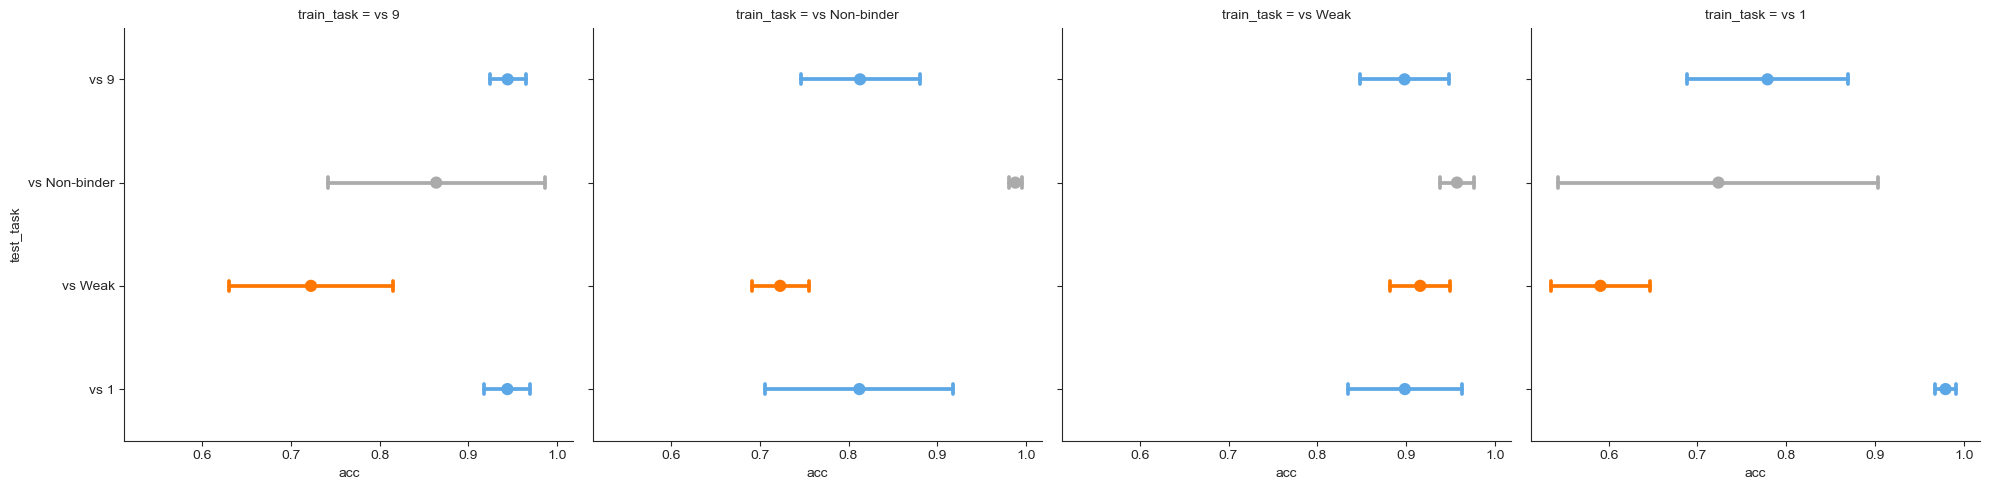

In [48]:
g_open_set_ag_agnostic = sns.catplot(perf_df, kind = 'point', errorbar= 'sd', join=False, capsize=.1, x = 'acc', y = 'test_task', col = 'train_task', palette = pellets['color_blind_dark'], legend = True)
axs = g_open_set_ag_agnostic.axes[0]
axs[0].axvline(get_closed_mean('ONE_VS_NINE', 'acc') ,ls='--', color=pellets['color_blind_dark'][0])
axs[1].axvline(get_closed_mean('HIGH_VS_95LOW', 'acc') ,ls='--', color=pellets['color_blind_dark'][1])
axs[2].axvline(get_closed_mean('HIGH_VS_LOOSER', 'acc') ,ls='--', color=pellets['color_blind_dark'][2])
#set y label
g_open_set_ag_agnostic.set_ylabels('Test task', fontsize=12)
#set x label
g_open_set_ag_agnostic.set_xlabels('Accuracy', fontsize=12)
#'r_like':['#94669E', '#F2D81D', '#00817A']}

In [49]:
tasks = perf_df['train_task'].unique()

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_97711/858749079.py:5: UserWarning: 
The palette list has fewer values (3) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.stripplot(
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_97711/858749079.py:5: UserWarning: 
The palette list has fewer values (3) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.stripplot(
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_97711/858749079.py:5: UserWarning: 
The palette list has fewer values (3) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.stripplot(


IndexError: index 3 is out of bounds for axis 0 with size 3

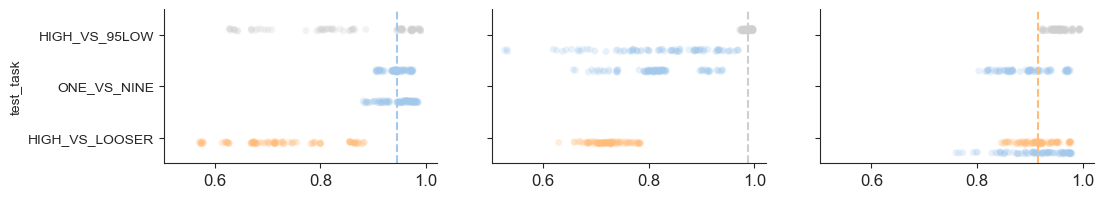

In [50]:
fig, ax = plt.subplots(1,3,figsize=(12, 2), sharey=True, sharex=True)
sns.set_style('ticks')
# set font size
for i, task in enumerate(tasks):
    sns.stripplot(
    perf_df[perf_df['train_task']== task], x = 'acc', y = 'test_task', hue="test_task",order = ['vs Non-binder', 'vs 9', 'vs Weak'], dodge=True, alpha=.25, zorder=1, legend=False, ax=ax[i], palette = pellets['color_blind_light'])

    ax[i].spines['left'].set_visible(True)
    ax[i].spines['bottom'].set_visible(True)

    sns.pointplot(
    perf_df[perf_df['train_task']==task],  x = 'acc', y = 'test_task', hue="test_task", order = ['HIGH_VS_95LOW', 'ONE_VS_NINE', 'HIGH_VS_LOOSER'], join=False, dodge=.8 - .8 / 3, palette=pellets['color_blind_dark'],
    markers="d", scale=.75, errorbar=None, ax=ax[i])
    #remove legend
    ax[i].legend().set_visible(False)

    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)

    ax[i].axvline(get_closed_mean(task, 'acc') ,ls='--', color=pellets['color_blind_light'][i])
    ax[i].tick_params(axis='x', which='major', labelsize=12)
    #remove x label
    ax[i].set_xlabel('')
ax[0].set_ylabel('Test task', fontsize=12)
#set x label
ax[1].set_xlabel('Accuracy', fontsize=12)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Accuracy')

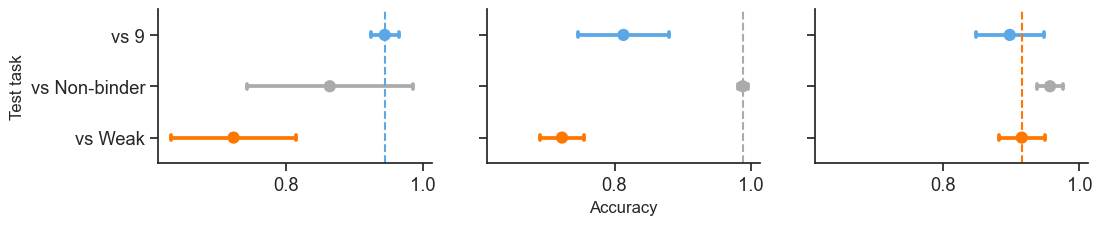

In [43]:
fig, ax = plt.subplots(1,3,figsize=(12, 2), sharey=True, sharex=True)
sns.set_style('ticks')
# set font size
for i, task in enumerate(tasks):
    sns.pointplot(perf_df[perf_df['train_task']== task], errorbar= 'sd', capsize=.1, x = 'acc', y = 'test_task', palette = pellets['color_blind_dark'], ax=ax[i])

    ax[i].spines['left'].set_visible(True)
    ax[i].spines['bottom'].set_visible(True)

    ax[i].legend().set_visible(False)

    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)

    ax[i].axvline(get_closed_mean(task, 'acc') ,ls='--', color=pellets['color_blind_dark'][i])
    #remove label from all
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    
ax[0].set_ylabel('Test task', fontsize=12)
#set x label
ax[1].set_xlabel('Accuracy', fontsize=12)


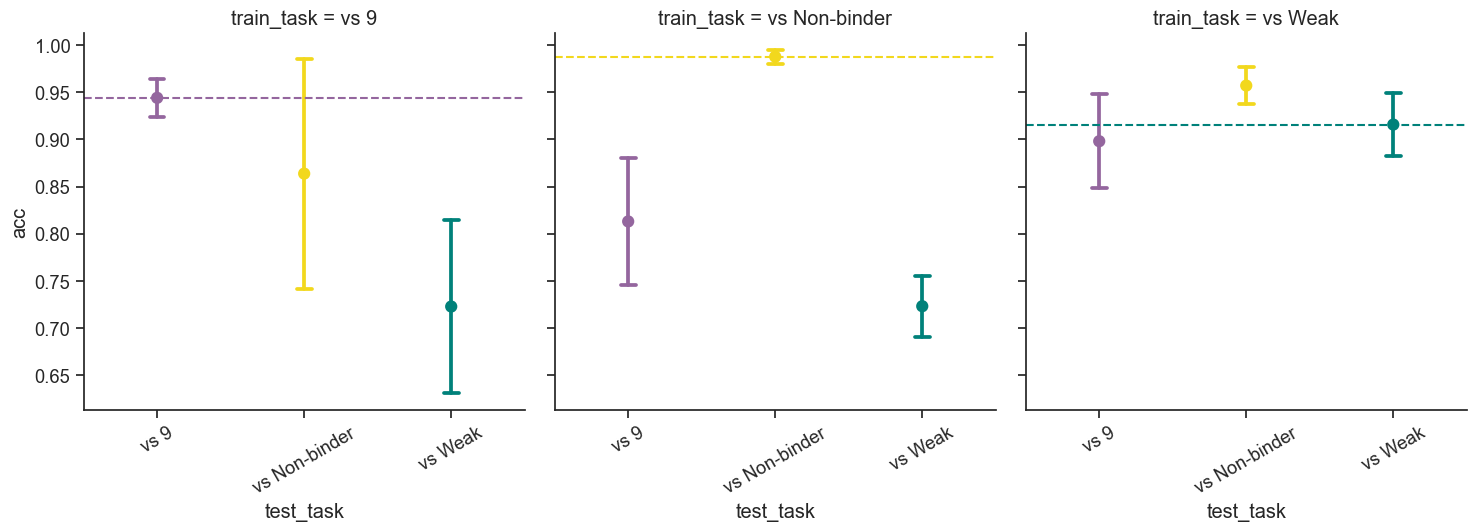

In [44]:
g_open_set_ag_agnostic = sns.catplot(perf_df, kind = 'point', errorbar= 'sd', join=False, capsize=.1, y = 'acc', x = 'test_task', col = 'train_task', palette = pellets['r_like'], legend = True).set_xticklabels(rotation=30)
axs = g_open_set_ag_agnostic.axes[0]
axs[0].axhline(get_closed_mean('vs 9', 'acc') ,ls='--', color='#94669E')
axs[1].axhline(get_closed_mean('vs Non-binder', 'acc') ,ls='--', color='#F2D81D')
axs[2].axhline(get_closed_mean('vs Weak', 'acc') ,ls='--', color='#00817A')
#'r_like':['#94669E', '#F2D81D', '#00817A']}

In [ ]:
#grid interfere with a trend
#color is not color blind friendly

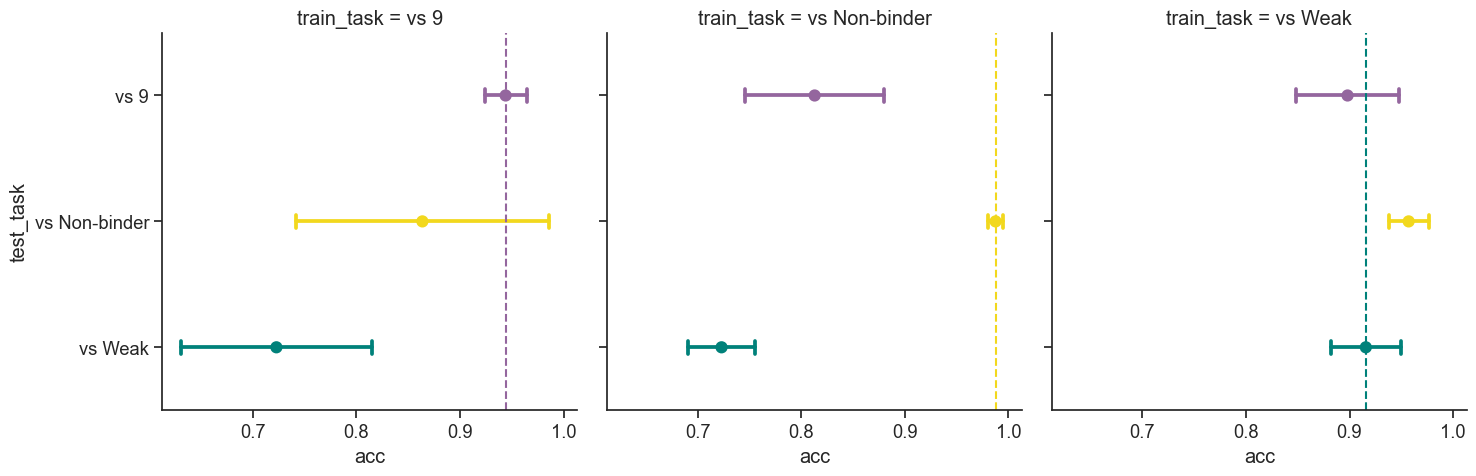

In [45]:
g_open_set_ag_agnostic = sns.catplot(perf_df, kind = 'point', errorbar= 'sd', join=False, capsize=.1, x = 'acc', y = 'test_task', col = 'train_task', palette = pellets['r_like'], legend = True)
axs = g_open_set_ag_agnostic.axes[0]
axs[0].axvline(get_closed_mean('vs 9', 'acc') ,ls='--', color='#94669E')
axs[1].axvline(get_closed_mean('vs Non-binder', 'acc') ,ls='--', color='#F2D81D')
axs[2].axvline(get_closed_mean('vs Weak', 'acc') ,ls='--', color='#00817A')

In [ ]:
g_open_set_ag_agnostic.savefig('openset_performance_by_task_rlike.png')

In [ ]:
ydata = perf_open_df['delta_acc'].values
xdata = perf_open_df['delta_jsd'].values
p0 = [max(ydata), np.median(xdata),1,min(ydata)] # this is an mandatory initial guess

popt, pcov = curve_fit(sigmoid, xdata, ydata, p0)

plt.plot(perf_open_df['delta_jsd'],perf_open_df['delta_acc'], 'o', label='data')
plt.plot(perf_open_df['delta_jsd'].sort_values(), sigmoid(perf_open_df['delta_jsd'].sort_values(), *popt), 'r-', label='fit')

sns.scatterplot(
        x="delta_jsd",
        y="delta_acc",
        data=perf_open_df,
        #hue='train_task',
        hue='train_ag',
        #palette=cmap,
        ax=ax,
    )
print(popt)